<a href="https://colab.research.google.com/github/probml/boljax/blob/main/boljax/kalman/demos/mnist_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports and Dataset

In [1]:
# import os
# import jax

# def setup_tpu(machine):
#     # Allow splitting of multi chip TPU VM 3 into 4 machines, 2 cores per machine
#     # https://gist.github.com/skye/f82ba45d2445bb19d53545538754f9a3
#     os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
#     os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
#     os.environ["TPU_VISIBLE_DEVICES"] = str(machine) # "0", .., "3"
#     print(jax.devices())

# setup_tpu(0)

In [2]:
try:
    import flax
    import optax
    import ml_collections
    import chex
    import tensorflow
    import tensorflow_datasets
except ModuleNotFoundError:
    %pip install flax
    %pip install optax
    %pip install ml_collections
    %pip install chex
    %pip install tensorflow
    %pip install tensorflow_datasets
    import flax 
    import optax
    import ml_collections
    import chex
    import tensorflow
    import tensorflow_datasets

2022-12-06 16:37:14.678597: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2022-12-06 16:37:15.408082: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2022-12-06 16:37:15.408193: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2022-12-06 16:37:15.408202: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use

In [3]:
try:
    from dynamax.linear_gaussian_ssm.inference import PosteriorGSSMFiltered
    from dynamax.generalized_gaussian_ssm.inference import _condition_on, EKFIntegrals, UKFIntegrals, GHKFIntegrals, conditional_moments_gaussian_filter
    from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install dynamax
    from dynamax.linear_gaussian_ssm.inference import PosteriorGSSMFiltered
    from dynamax.generalized_gaussian_ssm.inference import _condition_on, EKFIntegrals, UKFIntegrals, GHKFIntegrals, conditional_moments_gaussian_filter
    from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM

In [4]:
import gc
from functools import partial
import time
from typing import Callable, Sequence
import collections.abc
import warnings
import copy
from collections import deque

import ml_collections
import tensorflow_datasets as tfds
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalDiag as MVND
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from flax import linen as nn
from flax.training import train_state
import jax
from jax import jit, vmap, lax, jacfwd
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import jax.random as jr
import optax
from sklearn.preprocessing import OneHotEncoder
import numpy as np

from dynamax.generalized_gaussian_ssm.dekf.diagonal_inference import (
    DEKFParams,
    _full_covariance_condition_on,
    _stationary_dynamics_diagonal_predict,
    _fully_decoupled_ekf_condition_on,
    stationary_dynamics_fully_decoupled_conditional_moments_gaussian_filter,
    _variational_diagonal_ekf_condition_on,
    stationary_dynamics_variational_diagonal_extended_kalman_filter,
    _jacrev_2d,
)
from dynamax.generalized_gaussian_ssm.dekf.optimizer import (
    CMGFOptimizerParams,
    CMGFOptimizer,
    FDEKFOptimizer,
    VDEKFOptimizer,
)

In [5]:
jax.numpy.set_printoptions(suppress = True, precision=4)

In [6]:
def get_datasets():
    """Load MNIST train and test datasets into memory."""
    ds_builder = tfds.builder('mnist')
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    train_partial_ds = tfds.as_numpy(ds_builder.as_dataset(split='train[:5000]', batch_size=-1))
    train_tvsplit_ds = tfds.as_numpy(ds_builder.as_dataset(split='train[:80%]', batch_size=-1))
    val_tvsplit_ds = tfds.as_numpy(ds_builder.as_dataset(split='train[80%:]', batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
    for ds in [train_ds, train_partial_ds, train_tvsplit_ds, val_tvsplit_ds, test_ds]:
        ds['image'] = jnp.float32(ds['image']) / 255.
    return train_ds, test_ds, train_partial_ds, train_tvsplit_ds, val_tvsplit_ds

In [124]:
def get_config(
    optimizer='sgd',
    learning_rate=0.01, 
    momentum=2e-1,
    init_var=3e-2,
    num_iter=1,
    batch_size=1, 
    num_epochs=1,
    sample_freq=500,
    posterior_predictive_method='mc',
    seed=0
    ):
    """Get the default hyperparameter configuration."""
    config = ml_collections.ConfigDict()
    config.optimizer = optimizer
    config.learning_rate = learning_rate
    config.momentum = momentum
    config.init_var = init_var
    config.num_iter = num_iter
    config.batch_size = batch_size
    config.num_epochs = num_epochs
    config.sample_freq = sample_freq
    config.posterior_predictive_method = posterior_predictive_method
    config.seed = seed
    return config

In [72]:
train_ds, test_ds, train_partial_ds, train_tvsplit_ds, val_tvsplit_ds = get_datasets()

# 1. Optax Optimizers

In [15]:
class CNN(nn.Module):
    """A simple CNN model."""
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

In [16]:
from typing import NamedTuple, Optional, Any

import chex
from optax._src import base

In [17]:
class EKFState(NamedTuple):
    mean: base.Updates
    cov: base.Updates

In [18]:
def make_ekf_optimizer(
    pred_mean_fn,
    pred_cov_fn,
    init_var = 1.0,
    ekf_type = 'fcekf',
    num_iter = 1
    ) -> base.GradientTransformation:
    if ekf_type not in ['fcekf', 'fdekf', 'vdekf']:
        raise ValueError(f"'ekf_type' must be one of ['fcekf, 'fdekf', 'vdekf']")
    
    def init_fn(params):
        flat_params, _ = ravel_pytree(params)
        if ekf_type == 'fcekf':
            cov = init_var * jnp.eye(flat_params.shape[0])
        else:
            cov = init_var * jnp.ones_like(flat_params)
        return EKFState(mean=params, cov=cov)
    
    @jit
    def update_fn(updates, state, params=None):
        # Updates are new set of data points
        x, y = updates
        flat_mean, unflatten_fn = ravel_pytree(state.mean)
        if ekf_type == 'fcekf':
            mean, cov = _full_covariance_condition_on(
                flat_mean, state.cov, pred_mean_fn, pred_cov_fn, x, y, num_iter
            )
        elif ekf_type == 'fdekf':
            mean, cov = _fully_decoupled_ekf_condition_on(
                flat_mean, state.cov, pred_mean_fn, pred_cov_fn, x, y, num_iter
            )
        else:
            mean, cov = _variational_diagonal_ekf_condition_on(
                flat_mean, state.cov, pred_mean_fn, pred_cov_fn, x, y, num_iter
            )
        updates = unflatten_fn(mean - flat_mean)
        return updates, EKFState(mean=unflatten_fn(mean), cov=cov)
    
    return base.GradientTransformation(init_fn, update_fn)

In [19]:
@jit
def compute_loss_and_updates_sgd(state, batch_images, batch_labels):
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch_images)
        loss = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch_labels))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == batch_labels)
    return grads, loss, accuracy

@jit
def compute_loss_and_updates_ekf(state, batch_images, batch_labels):
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch_images)
        one_hot_labels = jax.nn.one_hot(batch_labels, logits.shape[-1]).ravel()
        loss = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch_labels))
        accuracy = jnp.mean(jnp.argmax(logits, -1) == batch_labels)
        return loss, accuracy, one_hot_labels

    loss, accuracy, one_hot_labels = loss_fn(state.params)
    updates = (batch_images, one_hot_labels)
    return updates, loss, accuracy

In [20]:
def create_train_state(config, nn_model_type='cnn', features=None):
    """Creates initial `TrainState`."""
    # Initialize NN model
    key, subkey = jr.split(jr.PRNGKey(config.seed))
    if nn_model_type == 'cnn':
        nn_model = CNN()
        params = nn_model.init(key, jnp.ones([1, 28, 28, 1]))['params']
    elif nn_model_type == 'mlp':
        if features is None:
            features = [25, 25, 10]
        nn_model = MLP(features)
        params = nn_model.init(key, jnp.ones([1, 28, 28, 1]).ravel())['params']
    else:
        raise ValueError(f"'nn_model_type' should be either 'cnn' or 'mlp'.")
    
    # Create trainstate
    if config.optimizer == 'sgd':
        tx = optax.sgd(config.learning_rate, config.momentum)
        compute_loss_and_updates = compute_loss_and_updates_sgd
    else:
        _, unflatten_fn = ravel_pytree(params)
        pred_mean_fn = lambda w, x: jax.nn.softmax(nn_model.apply({'params': unflatten_fn(w)}, x).ravel())
        def pred_cov_fn(w, x):
            ps = pred_mean_fn(w, x)
            return jnp.diag(ps) - jnp.outer(ps, ps)
        tx = make_ekf_optimizer(
            pred_mean_fn, pred_cov_fn, config.init_var, config.optimizer, config.num_iter
        )
        compute_loss_and_updates = compute_loss_and_updates_ekf
    opt_state = train_state.TrainState.create(apply_fn=nn_model.apply, params=params, tx=tx)
    return opt_state, compute_loss_and_updates, subkey

In [21]:
def train_model(config, train_ds, test_ds, nn_model_type='cnn', features=None):
    opt_state, compute_loss_and_updates, subkey = create_train_state(config, nn_model_type, features)
    train_ds_size = len(train_ds['image'])
    steps_per_epoch = train_ds_size // config.batch_size

    @jit
    def apply_updates(state, updates):
        return state.apply_gradients(grads=updates)
    
    steps, sampled_states = [], []
    for epoch in range(1, config.num_epochs+1):
        key, subkey = jr.split(subkey)

        # Shuffle training data and reshape according to batch size
        perms = jr.permutation(key, len(train_ds['image']))
        perms = perms[:steps_per_epoch * config.batch_size]  # skip incomplete batch
        perms = perms.reshape((steps_per_epoch, config.batch_size))

        # Stop early if desired
        if 'max_steps' in config:
            perms = perms[:config.max_steps]
        
        losses, accs = [], []

        pbar = tqdm(perms, desc=f'avg loss: 0.0; avg accuracy: 0.0')
        for i, perm in enumerate(pbar):
            batch_images = train_ds['image'][perm, ...]
            batch_labels = train_ds['label'][perm, ...]
            updates, loss, acc = compute_loss_and_updates(opt_state, batch_images, batch_labels)
            losses.append(loss)
            accs.append(acc)
            opt_state = apply_updates(opt_state, updates)
            if i%config.sample_freq == config.sample_freq-1:
                msg = ('avg loss: ' + f'{jnp.array(losses[-config.sample_freq:]).mean():.3f}; ' +
                       'avg accuracy: ' + f'{jnp.array(accs[-config.sample_freq:]).mean():.3f}')
                pbar.set_description(msg)
                steps.append(opt_state.step)
                sampled_states.append(opt_state.opt_state)

    return opt_state, steps, sampled_states

In [107]:
@jit
def evaluate_neg_log_likelihood(state, params, test_set):
    """ Evaluate negative log likelihood for given parameters and test set
    """
    @jit
    def evaluate_nll(state, params, label, image):
        image = image.reshape((1, 28, 28, 1))
        logits = state.apply_fn({'params': params}, image).ravel()
        return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=label)
    nlls = vmap(evaluate_nll, (None, None, 0, 0))(state, params, test_set['label'], test_set['image'])
    return nlls.mean()

@jit
def evaluate_accuracy(state, params, test_set):
    """ Evaluate accuracy given parameters and test state
    """
    @jit
    def misclassification(state, params, label, image):
        image = image.reshape((1, 28, 28, 1))
        logits = state.apply_fn({'params': params}, image).ravel()
        return jnp.where(jnp.argmax(logits) == label, 0, 1)
    miscl = vmap(misclassification, (None, None, 0, 0))(state, params, test_set['label'], test_set['image'])
    return miscl.sum()/len(miscl)

@jit
def evaluate_linearized_neg_log_likelihood(state, params, param_map, test_set):
    """ Evaluate linearized negative log likelihood for given parameters and test set
    """
    flat_params, unflatten_fn = ravel_pytree(params)
    
    @jit
    def evaluate_nll(label, image):
        image = image.reshape((1, 28, 28, 1))
        apply = lambda p: state.apply_fn({'params': unflatten_fn(p)}, image).ravel()
        H = _jacrev_2d(apply, param_map)
        logits = apply(param_map).ravel() + H @ (flat_params - param_map)
        return -jnp.log(jnp.exp(logits[label])/jnp.sum(jnp.exp(logits)))
    nlls = vmap(evaluate_nll, (0, 0))(test_set['label'], test_set['image'])
    return nlls.mean()

@jit
def evaluate_linearized_accuracy(state, params, param_map, test_set):
    """ Evaluate linearized accuracy given parameters and test state
    """
    flat_params, unflatten_fn = ravel_pytree(params)

    @jit
    def misclassification(label, image):
        image = image.reshape((1, 28, 28, 1))
        apply = lambda p: state.apply_fn({'params': unflatten_fn(p)}, image).ravel()
        logits = apply(param_map).ravel() + \
            (_jacrev_2d(apply, param_map) @ (flat_params - param_map)).ravel()
        return jnp.where(jnp.argmax(logits) == label, 0, 1)
    miscl = vmap(misclassification, (0, 0))(test_set['label'], test_set['image'])
    return miscl.sum()/len(miscl)

In [108]:
def evaluate_model(config, opt_state, sampled_states, test_ds):
    nlls, accs = [], []
    for sampled_state in tqdm(sampled_states):
        mean, cov = sampled_state
        if config.optimizer == 'sgd' or config.posterior_predictive_method == 'plugin':
            if config.optimizer == 'sgd':
                mean = mean.trace
            nlls.append(evaluate_neg_log_likelihood(opt_state, mean, test_ds))
            accs.append(evaluate_accuracy(opt_state, mean, test_ds))
    return nlls, accs

In [125]:
config = get_config(optimizer='sgd')

In [126]:
opt_state, steps, sampled_states = train_model(config, train_ds, test_ds)

avg loss: 0.040; avg accuracy: 0.988: 100%|██████████| 60000/60000 [03:21<00:00, 298.00it/s]


In [127]:
nlls, accs = evaluate_model(config, opt_state, sampled_states, train_ds)

100%|██████████| 120/120 [00:52<00:00,  2.30it/s]


In [ ]:
nlls

In [123]:
index = 100
image = train_ds['image'][index].reshape((1, 28, 28, 1))
label = train_ds['label'][index]
print(opt_state.apply_fn({'params': sampled_states[-2][0].trace}, image).ravel())
print(label)

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
9


In [120]:
label

9

# 1. Training Setup

##1.1 CNN and MLP Models

In [8]:
class CNN(nn.Module):
    """A simple CNN model."""
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

In [9]:
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

In [10]:
def create_train_state(key, config):
    """Creates initial `TrainState`."""
    cnn = CNN()
    params = cnn.init(key, jnp.ones([1, 28, 28, 1]))['params']
    tx = optax.sgd(config.learning_rate, config.momentum)
    return train_state.TrainState.create(
        apply_fn=cnn.apply, params=params, tx=tx)

In [11]:
def create_train_state_mlp(key, config, features):
    mlp = MLP(features)
    params = mlp.init(key, jnp.ones([1, 28, 28, 1]).ravel())['params']
    tx = optax.sgd(config.learning_rate, config.momentum)
    return train_state.TrainState.create(
        apply_fn=mlp.apply, params=params, tx=tx)

## 1.2 Training Steps - SGD

In [12]:
# SGD Training Steps
@jit
def apply_model_sgd(state, images, labels):
    """Computes gradients, loss and accuracy for a single batch."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, images)
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return grads, loss, accuracy

@jit
def update_model_sgd(state, grads):
    return state.apply_gradients(grads=grads)

def train_epoch_sgd(state, train_ds, batch_size, result, params_interval, key, polyak_averaging, polyak_window,
                    grid_search=False, grid_search_size=10000):
    """Train for a single epoch."""
    train_ds_size = len(train_ds['image'])
    if grid_search:
        train_ds_size = grid_search_size
    steps_per_epoch = train_ds_size // batch_size

    perms = jax.random.permutation(key, len(train_ds['image']))
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))

    epoch_loss = []
    epoch_accuracy = []
    params_history = deque()
    _, unflatten_fn = ravel_pytree(state.params)

    pbar = tqdm(perms, desc=f'loss-scaled mean accuracy: 0; mean accuracy: 0')
    for i, perm in enumerate(pbar):
        batch_images = train_ds['image'][perm, ...]
        batch_labels = train_ds['label'][perm, ...]
        grads, loss, accuracy = apply_model_sgd(state, batch_images, batch_labels)
        state = update_model_sgd(state, grads)
        if polyak_averaging:
            flattened_params, _ = ravel_pytree(state.params)
            params_history.append(flattened_params)
            if len(params_history) == polyak_window+1:
                params_history.popleft()

        if not grid_search and i%params_interval == (params_interval-1):
            if polyak_averaging:
                averaged_params = unflatten_fn(jnp.array(params_history).mean(axis=0))
                result[f'param_per_{params_interval}_batches'].append(averaged_params)
            else:
                result[f'param_per_{params_interval}_batches'].append(state.params)
            message = ('loss-scaled mean accuracy: ' +
                  f'{jnp.exp(-jnp.mean(jnp.array(epoch_loss[i-(params_interval-1):i+1]))):.3f}' +
                  '; mean accuracy: ' + f'{jnp.mean(jnp.array(epoch_accuracy[i-(params_interval-1):i+1])):.3f}')
            pbar.set_description(message)
        
        # If grid-searching, return average NLL over latter half of iterations
        if grid_search and i == grid_search_size-1:
            return jnp.mean(jnp.array(epoch_loss[int(i-grid_search_size/2):]))
            
        epoch_loss.append(loss)
        epoch_accuracy.append(accuracy)
    train_loss = jnp.mean(jnp.array(epoch_loss))
    train_accuracy = jnp.mean(jnp.array(epoch_accuracy))
    return state, train_loss, train_accuracy

def train_and_evaluate_sgd(train_ds, config, train_with_MLP=False, features=None, 
                           params_interval=600, key=0, polyak_averaging=False, 
                           polyak_window=300, grid_search=False, grid_search_size=10000):
    """Execute model training and evaluation loop.
    """
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jax.random.split(key)

    if train_with_MLP:
        state = create_train_state_mlp(key, config, features)
    else:
        state = create_train_state(key, config)

    result = {f'param_per_{params_interval}_batches': [], 'run_time_per_epoch': []}

    if grid_search:
        return train_epoch_sgd(state, train_ds, config.batch_size, result, 
                               params_interval, key, polyak_averaging, 
                               polyak_window, grid_search, grid_search_size)
    
    for epoch in range(1, config.num_epochs + 1):
        start = time.time()
        key, subkey = jax.random.split(subkey)
        state, train_loss, train_accuracy = train_epoch_sgd(state, train_ds, config.batch_size,
                                                            result, params_interval, key,
                                                            polyak_averaging, polyak_window)
        result['run_time_per_epoch'].append(time.time() - start)

    return state, result

## 1.3 Evaluation Steps

In [13]:
@jit
def evaluate_neg_log_likelihood(state, params, test_set):
    """ Evaluate negative log likelihood for given parameters and test set
    """
    @jit
    def evaluate_nll(state, params, label, image):
        image = image.reshape((1, 28, 28, 1))
        logits = state.apply_fn({'params': params}, image).ravel()
        return -jnp.log(jnp.exp(logits[label])/jnp.sum(jnp.exp(logits)))
    nlls = vmap(evaluate_nll, (None, None, 0, 0))(state, params, test_set['label'], test_set['image'])
    return nlls.mean()

@jit
def evaluate_accuracy(state, params, test_set):
    """ Evaluate accuracy given parameters and test state
    """
    @jit
    def misclassification(state, params, label, image):
        image = image.reshape((1, 28, 28, 1))
        logits = state.apply_fn({'params': params}, image).ravel()
        return jnp.where(jnp.argmax(logits) == label, 0, 1)
    miscl = vmap(misclassification, (None, None, 0, 0))(state, params, test_set['label'], test_set['image'])
    return miscl.sum()/len(miscl)

Locally-linearized versions (see https://arxiv.org/pdf/2008.08400.pdf)


In [14]:
@jit
def evaluate_locally_linearized_neg_log_likelihood(state, params, param_map, test_set):
    """ Evaluate negative log likelihood for given parameters and test set
    """
    flat_params, unflatten_fn = ravel_pytree(params)
    
    @jit
    def evaluate_nll(label, image):
        image = image.reshape((1, 28, 28, 1))
        apply = lambda p: state.apply_fn({'params': unflatten_fn(p)}, image).ravel()
        H = _jacrev_2d(apply, param_map)
        logits = apply(param_map).ravel() + H @ (flat_params - param_map)
        return -jnp.log(jnp.exp(logits[label])/jnp.sum(jnp.exp(logits)))
    nlls = vmap(evaluate_nll, (0, 0))(test_set['label'], test_set['image'])
    return nlls.mean()

@jit
def evaluate_locally_linearized_accuracy(state, params, param_map, test_set):
    """ Evaluate accuracy given parameters and test state
    """
    flat_params, unflatten_fn = ravel_pytree(params)

    @jit
    def misclassification(label, image):
        image = image.reshape((1, 28, 28, 1))
        apply = lambda p: state.apply_fn({'params': unflatten_fn(p)}, image).ravel()
        logits = apply(param_map).ravel() + \
            (_jacrev_2d(apply, param_map) @ (flat_params - param_map)).ravel()
        return jnp.where(jnp.argmax(logits) == label, 0, 1)
    miscl = vmap(misclassification, (0, 0))(test_set['label'], test_set['image'])
    return miscl.sum()/len(miscl)

## 1.4 Training Steps - EKF

In [15]:
def train_epoch_ekf(opt, model_params, state_ekf, state_model, ohe_train_ds, train_ds, test_ds, 
                    unflatten_fn, batch_size, result, params_interval, key, num_samples, ekf_type,
                    large_params, grid_search=False, grid_search_size=10000, map_estimate=False):
    """Train for a single epoch."""

    mean_fn, cov_fn = model_params.emission_mean_function, model_params.emission_cov_function

    train_ds_size = len(ohe_train_ds['image'])
    if grid_search:
        train_ds_size = grid_search_size
        grid_search_nlls = []
    steps_per_epoch = train_ds_size // batch_size

    # # Run dynamax CMGF on the entire training dataset (faster)
    # post = conditional_moments_gaussian_filter(model_params, EKFIntegrals(), train_ds['label'][:train_ds_size], inputs=jnp.expand_dims(train_ds['image'][:train_ds_size], axis=1))
    # return post

    perms = jax.random.permutation(key, len(ohe_train_ds['image']))
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    
    key, subkey = jr.split(key)
    
    @jit
    def compute_nlls(params, eval_set):
        return evaluate_neg_log_likelihood(state_model, unflatten_fn(params), eval_set)
    
    @jit
    def compute_accs(params, eval_set):
        return evaluate_accuracy(state_model, unflatten_fn(params), eval_set)

    pbar = tqdm(perms, desc=f'test_nll = ')
    for i, perm in enumerate(pbar):
        batch_images = ohe_train_ds['image'][perm, ...]
        batch_labels = (ohe_train_ds['label'][perm, ...]).ravel()
        _, state_ekf = opt.update(batch_images, mean_fn, cov_fn, batch_labels, state_ekf)
        
        # if i%300 == 0:
        #     print(perm)
        #     print(f'true_label = {batch_labels}')
        #     print(mean_fn(state_ekf.mean, batch_images))

        if i%params_interval == (params_interval-1):
            key, subkey = jr.split(subkey)
            if ekf_type == 'fcekf':
                mvn = MVN(loc=state_ekf.mean, covariance_matrix=state_ekf.cov)
            else:
                mvn = MVND(loc=state_ekf.mean, scale_diag=state_ekf.cov)
            sampled_params = mvn.sample(seed=key, sample_shape=num_samples)
            if map_estimate:
                sampled_params = jnp.array([state_ekf.mean])

            if large_params:
                train_nlls, test_nlls, train_accs, test_accs = [], [], [], []
                for sampled_param in sampled_params:
                    # train_nlls.append(compute_nlls(sampled_param, train_ds))
                    test_nlls.append(compute_nlls(sampled_param, test_ds))
                    # train_accs.append(compute_accs(sampled_param, train_ds))
                    test_accs.append(compute_accs(sampled_param, test_ds))
            else:
                # train_nlls = jit(vmap(compute_nlls, (0, None)))(sampled_params, train_ds)
                test_nlls = jit(vmap(compute_nlls, (0, None)))(sampled_params, test_ds)
                # train_accs = jit(vmap(compute_accs, (0, None)))(sampled_params, train_ds)
                test_accs = jit(vmap(compute_accs, (0, None)))(sampled_params, test_ds)
            # result[f'nll_train_per_{params_interval}_batches'].append(jnp.array(train_nlls).mean())
            result[f'nll_test_per_{params_interval}_batches'].append(jnp.array(test_nlls).mean())
            pbar.set_description(desc=f'test_nll = {jnp.array(test_nlls).mean()}')
            if grid_search and jnp.isnan(jnp.array(test_nlls).mean()):
                return jnp.nan

            # result[f'acc_train_per_{params_interval}_batches'].append(jnp.array(train_accs).mean())
            result[f'acc_test_per_{params_interval}_batches'].append(jnp.array(test_accs).mean())
        
        # If grid-searching, return average of test-set NLLs at end of grid search and and halfway through.
        if grid_search and i == grid_search_size-1:
            grid_nlls = result[f'nll_test_per_{params_interval}_batches']
            print(grid_nlls)
            return jnp.array(grid_nlls).mean()

    return state_ekf, result


In [16]:
def train_epoch_ekf_immer(opt, model_params, state_ekf, state_model, ohe_train_ds, train_ds, test_ds, 
                          unflatten_fn, batch_size, result, params_interval, key, num_samples, ekf_type,
                          large_params):
    """Train for a single epoch."""

    mean_fn, cov_fn = model_params.emission_mean_function, model_params.emission_cov_function

    train_ds_size = len(ohe_train_ds['image'])
    steps_per_epoch = train_ds_size // batch_size

    # # Run dynamax CMGF on the entire training dataset (faster)
    # post = conditional_moments_gaussian_filter(model_params, EKFIntegrals(), train_ds['label'][:train_ds_size], inputs=jnp.expand_dims(train_ds['image'][:train_ds_size], axis=1))
    # return post

    perms = jax.random.permutation(key, len(ohe_train_ds['image']))
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    
    key, subkey = jr.split(key)
    
    @jit
    def compute_nlls(params, param_map, eval_set):
        return evaluate_locally_linearized_neg_log_likelihood(state_model, unflatten_fn(params), 
                                                              param_map, eval_set)
    
    @jit
    def compute_accs(params, param_map, eval_set):
        return evaluate_locally_linearized_accuracy(state_model, unflatten_fn(params), 
                                                    param_map, eval_set)

    pbar = tqdm(perms, desc=f'test_nll = ')
    for i, perm in enumerate(pbar):
        batch_images = ohe_train_ds['image'][perm, ...]
        batch_labels = (ohe_train_ds['label'][perm, ...]).ravel()
        _, state_ekf = opt.update(batch_images, mean_fn, cov_fn, batch_labels, state_ekf)
        
        # if i%300 == 0:
        #     print(perm)
        #     print(f'true_label = {batch_labels}')
        #     print(mean_fn(state_ekf.mean, batch_images))

        if i%params_interval == (params_interval-1):
            key, subkey = jr.split(subkey)
            if ekf_type == 'fcekf':
                mvn = MVN(loc=state_ekf.mean, covariance_matrix=state_ekf.cov)
            else:
                mvn = MVND(loc=state_ekf.mean, scale_diag=state_ekf.cov)
            sampled_params = mvn.sample(seed=key, sample_shape=num_samples)
            del mvn

            if large_params:
                train_nlls, test_nlls, train_accs, test_accs = [], [], [], []
                for sampled_param in sampled_params:
                    # train_nlls.append(compute_nlls(sampled_param, state_ekf.mean, train_ds))
                    test_nlls.append(compute_nlls(sampled_param, state_ekf.mean, test_ds))
                    # train_accs.append(compute_accs(sampled_param, state_ekf.mean, train_ds))
                    test_accs.append(compute_accs(sampled_param, state_ekf.mean, test_ds))
            else:
                # train_nlls = jit(vmap(compute_nlls, (0, None, None)))(sampled_params, state_ekf.mean, train_ds)
                test_nlls = jit(vmap(compute_nlls, (0, None, None)))(sampled_params, state_ekf.mean, test_ds)
                # train_accs = jit(vmap(compute_accs, (0, None, None)))(sampled_params, state_ekf.mean, train_ds)
                test_accs = jit(vmap(compute_accs, (0, None, None)))(sampled_params, state_ekf.mean, test_ds)
            # result[f'nll_train_per_{params_interval}_batches'].append(jnp.array(train_nlls).mean())
            result[f'nll_test_per_{params_interval}_batches'].append(jnp.array(test_nlls).mean())
            pbar.set_description(desc=f'test_nll = {jnp.array(test_nlls).mean()}')

            # result[f'acc_train_per_{params_interval}_batches'].append(jnp.array(train_accs).mean())
            result[f'acc_test_per_{params_interval}_batches'].append(jnp.array(test_accs).mean())

    return state_ekf, result

In [17]:
def train_and_evaluate_ekf(train_ds, test_ds, config, ekf_type='fdekf', train_with_MLP=False, 
                           features=None, params_interval=600, key=0, num_samples=100, 
                           large_params=False, immer_linearize=True, grid_search=False, 
                           grid_search_size=10000, map_estimate=False):
    """Execute model training and evaluation loop.
    """
    if ekf_type not in ('fcekf', 'fdekf', 'vdekf'):
        raise ValueError('`ekf_type` should be one of (`fcekf`, `fdekf`, `vdekf`)')
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jax.random.split(key)
    if train_with_MLP:
        state_model = create_train_state_mlp(key, config, features)
    else:
        state_model = create_train_state(key, config)
    params = state_model.params
    flat_params, unflatten_fn = ravel_pytree(params)
    print(f'Params size = {flat_params.shape}')
    state_dim = flat_params.shape[0]

    # One-hot encode the labels
    enc = OneHotEncoder()
    ohe_train_ds = copy.deepcopy(train_ds)
    ohe_train_ds['label'] = jnp.array(enc.fit_transform(train_ds['label'].reshape(-1, 1)).toarray())

    apply_fn = lambda w, x: state_model.apply_fn({'params': unflatten_fn(w)}, x).ravel()
    emission_mean_function=lambda w, x: jax.nn.softmax(apply_fn(w, x))
    def emission_cov_function(w, x):
        ps = emission_mean_function(w, x)
        return jnp.diag(ps) - jnp.outer(ps, ps)
    
    if ekf_type == 'fcekf':
        opt = CMGFOptimizer()
        state_ekf = opt.init([flat_params, jnp.eye(flat_params.size) * config.init_var])
        model_params = ParamsGGSSM(
            initial_mean=state_ekf.mean,
            initial_covariance=state_ekf.cov,
            dynamics_function=lambda x: x,
            dynamics_covariance=None,
            emission_mean_function=emission_mean_function,
            emission_cov_function=emission_cov_function
        )
    else:
        if ekf_type == 'fdekf':
            opt = FDEKFOptimizer()
        else:
            opt = VDEKFOptimizer()
        state_ekf = opt.init([flat_params, jnp.ones(flat_params.size) * config.init_var])
        model_params = DEKFParams(
            initial_mean=state_ekf.mean,
            initial_cov_diag=state_ekf.cov,
            dynamics_cov_diag=jnp.ones((flat_params.size)) * 1e-4,
            emission_mean_function=emission_mean_function,
            emission_cov_function=emission_cov_function
        )

    result = {f'nll_train_per_{params_interval}_batches': [], f'acc_train_per_{params_interval}_batches': [],
              f'nll_test_per_{params_interval}_batches': [], f'acc_test_per_{params_interval}_batches': [],
              'run_time_per_epoch': []}

    if grid_search:
        return train_epoch_ekf(opt, model_params, state_ekf, state_model, ohe_train_ds,
                                train_ds, test_ds, unflatten_fn, config.batch_size, 
                                result, params_interval, key, num_samples, ekf_type, large_params,
                                grid_search, grid_search_size, map_estimate)
    
    for epoch in range(1, config.num_epochs + 1):
        start = time.time()
        key, subkey = jax.random.split(subkey)

        if map_estimate or not immer_linearize:
            state_param, result = train_epoch_ekf(opt, model_params, state_ekf, state_model, ohe_train_ds,
                                 train_ds, test_ds, unflatten_fn, config.batch_size, 
                                 result, params_interval, key, num_samples, ekf_type, large_params, 
                                 map_estimate=map_estimate)
        else:
            state_param, result = train_epoch_ekf_immer(opt, model_params, state_ekf, state_model, ohe_train_ds,
                                 train_ds, test_ds, unflatten_fn, config.batch_size, 
                                 result, params_interval, key, num_samples, ekf_type, large_params)
        
        result['run_time_per_epoch'].append(time.time() - start)
    result = {key: jnp.array(val) for key, val in result.items()}
    return state_model, state_param, result

# 2. SGD

## 2.1 CNN

In [64]:
# Perform grid search on learning_rate and momentum
learning_rates = momentums = jnp.array([0.2, 0.1, 1e-2, 1e-3, 1e-4, 1e-5])
grid_search_result = {'nll': 1.0, 'lr': 0.0, 'm': 0.0}
for lr in learning_rates:
    for m in momentums:
        print(f'Trying lr={lr:.5}, momentum={m:.5}...')
        config = get_config(learning_rate=lr, momentum=m)
        curr_nll = train_and_evaluate_sgd(train_ds, config, grid_search=True)
        print(f'Current nll={curr_nll:.3f}')
        if curr_nll and curr_nll < grid_search_result['nll']:
            grid_search_result['nll'] = curr_nll
            grid_search_result['lr'] = lr
            grid_search_result['m'] = m


Trying lr=0.2, momentum=0.2...


loss-scaled mean accuracy: 0; mean accuracy: 0:  17%|█▋        | 1669/10000 [00:07<00:38, 218.59it/s]


KeyboardInterrupt: 

In [79]:
# Grid search result: lr=0.01, momentum=0.2
# print(f'Grid search for SGD result: lr={grid_search_result["lr"]:.3f}, momentum={grid_search_result["m"]:.3f}')

In [51]:
config = get_config(learning_rate=0.01, momentum=0.2)
state_sgd, result_sgd = train_and_evaluate_sgd(train_ds, config)

loss-scaled mean accuracy: 0.672; mean accuracy: 0.883:   4%|▍         | 2650/60000 [00:11<04:07, 231.26it/s]


KeyboardInterrupt: 

In [19]:
params_interval = 600
x = jnp.arange(params_interval, len(train_ds['image'])+1, params_interval)
y_nll_sgd_test = []
y_nll_sgd_train = []
for i, param in enumerate(tqdm(result_sgd[f'param_per_{params_interval}_batches'])):
    # Evaluate nll on test set
    y_nll_sgd_test.append(evaluate_neg_log_likelihood(state_sgd, param, test_ds))

    # Evaluate nll on train set
    y_nll_sgd_train.append(evaluate_neg_log_likelihood(state_sgd, param, train_ds))

100%|██████████| 100/100 [00:28<00:00,  3.47it/s]


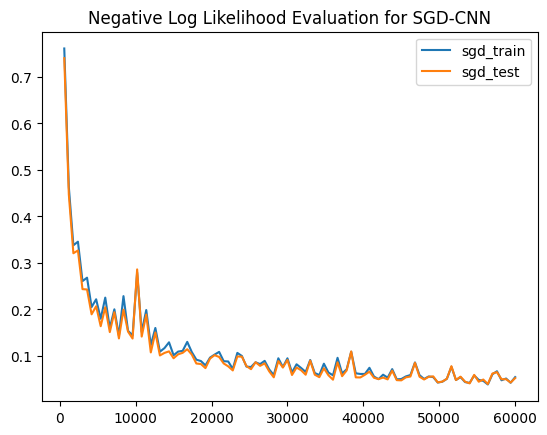

In [20]:
plt.plot(x, y_nll_sgd_train, label='sgd_train')
plt.plot(x, y_nll_sgd_test, label='sgd_test')
plt.title('Negative Log Likelihood Evaluation for SGD-CNN')
plt.legend();

In [21]:
y_acc_sgd_test = []
y_acc_sgd_train = []
for i, param in enumerate(tqdm(result_sgd[f'param_per_{params_interval}_batches'])):
    # Evaluate misclassification rate on test set
    y_acc_sgd_test.append(evaluate_accuracy(state_sgd, param, test_ds))

    # Evaluate misclassification rate on train set
    y_acc_sgd_train.append(evaluate_accuracy(state_sgd, param, train_ds))

100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


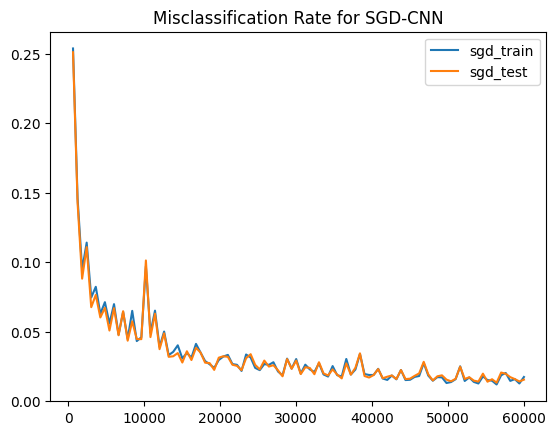

In [22]:
plt.plot(x, y_acc_sgd_train, label='sgd_train')
plt.plot(x, y_acc_sgd_test, label='sgd_test')
plt.title('Misclassification Rate for SGD-CNN')
plt.legend();

In [23]:
# Delete parameters from memory
del state_sgd, result_sgd

## 2.1.2 CNN - Focus on the first 5000 (Polyak-averaged)

In [98]:
config = get_config(learning_rate=0.01, momentum=0.2)
state_partial_sgd, result_partial_sgd = train_and_evaluate_sgd(train_partial_ds, config, params_interval=10, polyak_averaging=True, polyak_window=10)

loss-scaled mean accuracy: 0.851; mean accuracy: 1.000: 100%|██████████| 5000/5000 [00:39<00:00, 125.08it/s]


In [102]:
test_partial_ds = test_ds

params_partial_interval = 10
x_partial = jnp.arange(params_partial_interval, len(train_partial_ds['image'])+1, params_partial_interval)
y_nll_sgd_partial_test = []
y_nll_sgd_partial_train = []
for i, param in enumerate(tqdm(result_partial_sgd[f'param_per_{params_partial_interval}_batches'])):
    # Evaluate nll on test set
    y_nll_sgd_partial_test.append(evaluate_neg_log_likelihood(state_partial_sgd, param, test_ds))

    # Evaluate nll on train set
    y_nll_sgd_partial_train.append(evaluate_neg_log_likelihood(state_partial_sgd, param, train_partial_ds))

100%|██████████| 500/500 [00:20<00:00, 24.10it/s]


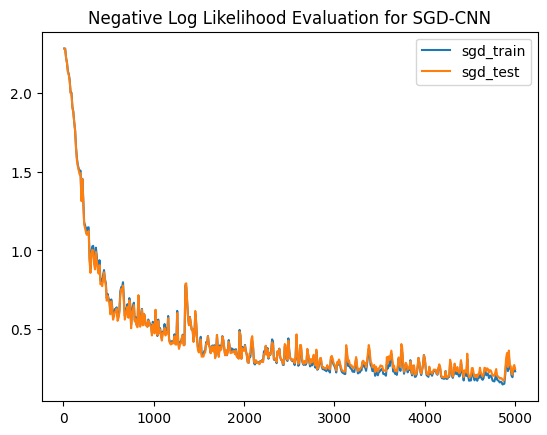

In [103]:
plt.plot(x_partial, y_nll_sgd_partial_train, label='sgd_train')
plt.plot(x_partial, y_nll_sgd_partial_test, label='sgd_test')
plt.title('Negative Log Likelihood Evaluation for SGD-CNN')
plt.legend();

In [106]:
y_acc_sgd_partial_test = []
y_acc_sgd_partial_train = []
for i, param in enumerate(tqdm(result_partial_sgd[f'param_per_{params_partial_interval}_batches'])):
    # Evaluate misclassification rate on test set
    y_acc_sgd_partial_test.append(evaluate_accuracy(state_partial_sgd, param, test_ds))

    # Evaluate misclassification rate on train set
    y_acc_sgd_partial_train.append(evaluate_accuracy(state_partial_sgd, param, train_partial_ds))

100%|██████████| 500/500 [00:30<00:00, 16.18it/s]


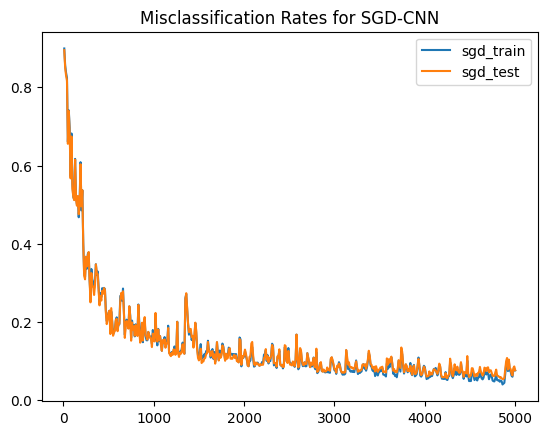

In [107]:
plt.plot(x_partial, y_acc_sgd_partial_train, label='sgd_train')
plt.plot(x_partial, y_acc_sgd_partial_test, label='sgd_test')
plt.title('Misclassification Rates for SGD-CNN')
plt.legend();

In [108]:
# Delete parameters from memory
del state_partial_sgd, result_partial_sgd

## 2.2 CNN - Polyak-averaged

In [24]:
state_sgd_polyak, result_sgd_polyak = train_and_evaluate_sgd(train_ds, config, polyak_averaging=True)

loss-scaled mean accuracy: 0.948; mean accuracy: 0.983: 100%|██████████| 60000/60000 [06:59<00:00, 142.89it/s]


In [25]:
params_interval = 600
x = jnp.arange(params_interval, len(train_ds['image'])+1, params_interval)
y_nll_sgd_polyak_test = []
y_nll_sgd_polyak_train = []
for i, param in enumerate(tqdm(result_sgd_polyak[f'param_per_{params_interval}_batches'])):
    # Evaluate nll on test set
    y_nll_sgd_polyak_test.append(evaluate_neg_log_likelihood(state_sgd_polyak, param, test_ds))

    # Evaluate nll on train set
    y_nll_sgd_polyak_train.append(evaluate_neg_log_likelihood(state_sgd_polyak, param, train_ds))

100%|██████████| 100/100 [00:28<00:00,  3.50it/s]


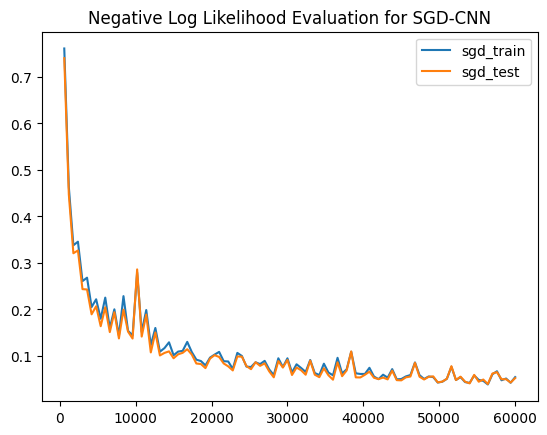

In [26]:
plt.plot(x, y_nll_sgd_train, label='sgd_train')
plt.plot(x, y_nll_sgd_test, label='sgd_test')
plt.title('Negative Log Likelihood Evaluation for SGD-CNN')
plt.legend();

In [27]:
y_acc_sgd_polyak_test = []
y_acc_sgd_polyak_train = []
for i, param in enumerate(tqdm(result_sgd_polyak[f'param_per_{params_interval}_batches'])):
    # Evaluate misclassification rate on test set
    y_acc_sgd_polyak_test.append(evaluate_accuracy(state_sgd_polyak, param, test_ds))

    # Evaluate misclassification rate on train set
    y_acc_sgd_polyak_train.append(evaluate_accuracy(state_sgd_polyak, param, train_ds))

100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


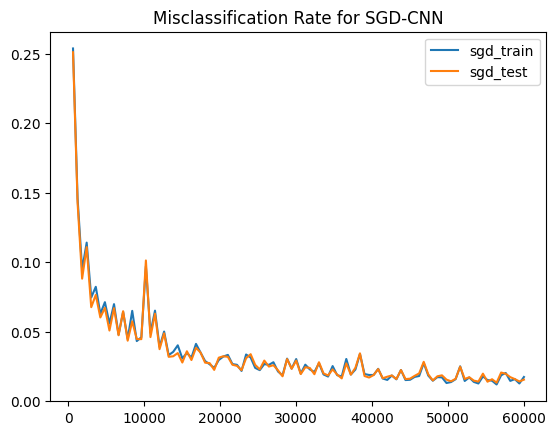

In [28]:
plt.plot(x, y_acc_sgd_train, label='sgd_train')
plt.plot(x, y_acc_sgd_test, label='sgd_test')
plt.title('Misclassification Rate for SGD-CNN')
plt.legend();

In [29]:
# Delete parameters from memory
del state_sgd_polyak, result_sgd_polyak

## 2.3 MLP

In [18]:
features = [25, 25, 25, 10]

# Perform grid search on learning_rate and momentum
learning_rates = momentums = jnp.array([0.2, 0.1, 1e-2, 1e-3, 1e-4, 1e-5])
grid_search_result_sgd_mlp = {'nll': 1.0, 'lr': 0.0, 'm': 0.0}
for lr in learning_rates:
    for m in momentums:
        print(f'Trying lr={lr:.5}, momentum={m:.5}...')
        config = get_config(learning_rate=lr, momentum=m)
        curr_nll = train_and_evaluate_sgd(train_ds, config, train_with_MLP=True,
                                          features=features, grid_search=True)
        print(f'Current nll={curr_nll:.3f}')
        if curr_nll and curr_nll < grid_search_result_sgd_mlp['nll']:
            grid_search_result_sgd_mlp['nll'] = curr_nll
            grid_search_result_sgd_mlp['lr'] = lr
            grid_search_result_sgd_mlp['m'] = m


Trying lr=0.2, momentum=0.2...


KeyboardInterrupt: 

In [ ]:
# Grid search result: lr=0.01, momentum=0.2
print(f'Grid search for SGD result: lr={grid_search_result_sgd_mlp["lr"]:.3f}, momentum={grid_search_result_sgd_mlp["m"]:.3f}')

In [71]:
features = [25, 25, 25, 10]
state_sgd_mlp, result_sgd_mlp = train_and_evaluate_sgd(train_ds, config, train_with_MLP=True, features=features)

loss-scaled mean accuracy: 0.793; mean accuracy: 0.927: 100%|██████████| 60000/60000 [02:46<00:00, 360.82it/s]


In [72]:
params_interval = 600
x = jnp.arange(params_interval, len(train_ds['image'])+1, params_interval)
y_nll_sgd_mlp_test = []
y_nll_sgd_mlp_train = []
for i, param in enumerate(tqdm(result_sgd_mlp[f'param_per_{params_interval}_batches'])):
    # Evaluate nll on test set
    y_nll_sgd_mlp_test.append(evaluate_neg_log_likelihood(state_sgd_mlp, param, test_ds))

    # Evaluate nll on train set
    y_nll_sgd_mlp_train.append(evaluate_neg_log_likelihood(state_sgd_mlp, param, train_ds))

100%|██████████| 100/100 [00:00<00:00, 138.13it/s]


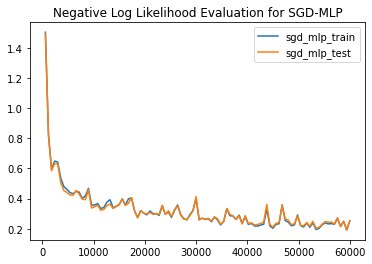

In [73]:
plt.plot(x, y_nll_sgd_mlp_train, label='sgd_mlp_train')
plt.plot(x, y_nll_sgd_mlp_test, label='sgd_mlp_test')
plt.title('Negative Log Likelihood Evaluation for SGD-MLP')
plt.legend();

In [74]:
y_acc_sgd_mlp_test = []
y_acc_sgd_mlp_train = []
for i, param in enumerate(tqdm(result_sgd_mlp[f'param_per_{params_interval}_batches'])):
    # Evaluate misclassification rate on test set
    y_acc_sgd_mlp_test.append(evaluate_accuracy(state_sgd_mlp, param, test_ds))

    # Evaluate misclassification rate on train set
    y_acc_sgd_mlp_train.append(evaluate_accuracy(state_sgd_mlp, param, train_ds))

100%|██████████| 100/100 [00:00<00:00, 171.20it/s]


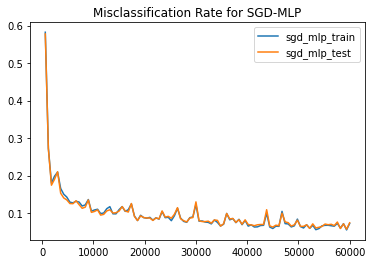

In [75]:
plt.plot(x, y_acc_sgd_mlp_train, label='sgd_mlp_train')
plt.plot(x, y_acc_sgd_mlp_test, label='sgd_mlp_test')
plt.title('Misclassification Rate for SGD-MLP')
plt.legend();

In [76]:
# Delete parameters from memory
del state_sgd_mlp, result_sgd_mlp

## 2.3 MLP - Polyak-averaged

In [122]:
features = [25, 25, 25, 10]
state_sgd_mlp_polyak, result_sgd_mlp_polyak = train_and_evaluate_sgd(train_ds, config, train_with_MLP=True, features=features, polyak_averaging=True)

loss-scaled mean accuracy: 0.317; mean accuracy: 0.594:   2%|▏         | 1316/60000 [00:08<05:57, 164.14it/s]


KeyboardInterrupt: 

In [78]:
params_interval = 600
x = jnp.arange(params_interval, len(train_ds['image'])+1, params_interval)
y_nll_sgd_mlp_polyak_test = []
y_nll_sgd_mlp_polyak_train = []
for i, param in enumerate(tqdm(result_sgd_mlp_polyak[f'param_per_{params_interval}_batches'])):
    # Evaluate nll on test set
    y_nll_sgd_mlp_polyak_test.append(evaluate_neg_log_likelihood(state_sgd_mlp_polyak, param, test_ds))

    # Evaluate nll on train set
    y_nll_sgd_mlp_polyak_train.append(evaluate_neg_log_likelihood(state_sgd_mlp_polyak, param, train_ds))

100%|██████████| 100/100 [00:00<00:00, 129.85it/s]


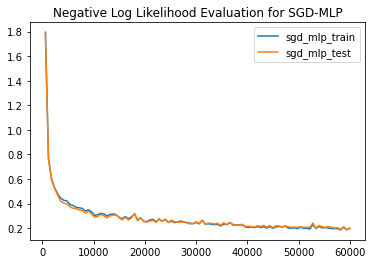

In [79]:
plt.plot(x, y_nll_sgd_mlp_polyak_train, label='sgd_mlp_train')
plt.plot(x, y_nll_sgd_mlp_polyak_test, label='sgd_mlp_test')
plt.title('Negative Log Likelihood Evaluation for SGD-MLP')
plt.legend();

In [80]:
y_acc_sgd_mlp_polyak_test = []
y_acc_sgd_mlp_polyak_train = []
for i, param in enumerate(tqdm(result_sgd_mlp_polyak[f'param_per_{params_interval}_batches'])):
    # Evaluate misclassification rate on test set
    y_acc_sgd_mlp_polyak_test.append(evaluate_accuracy(state_sgd_mlp_polyak, param, test_ds))

    # Evaluate misclassification rate on train set
    y_acc_sgd_mlp_polyak_train.append(evaluate_accuracy(state_sgd_mlp_polyak, param, train_ds))

100%|██████████| 100/100 [00:00<00:00, 239.95it/s]


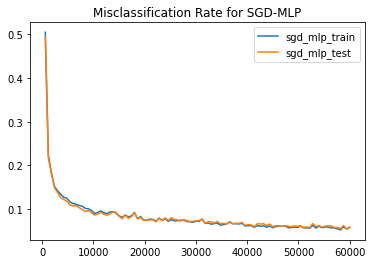

In [81]:
plt.plot(x, y_acc_sgd_mlp_polyak_train, label='sgd_mlp_train')
plt.plot(x, y_acc_sgd_mlp_polyak_test, label='sgd_mlp_test')
plt.title('Misclassification Rate for SGD-MLP')
plt.legend();

In [82]:
# Delete parameters from memory
del state_sgd_mlp_polyak, result_sgd_mlp_polyak

# 3. Full-Covariance EKF

In [19]:
features = [25, 25, 25, 10]

# Perform grid search on initial covariance
config = get_config()
grid_search_result_fcekf = {'nll': 1.0, 'init_var': 0.0}
init_vars = np.array([jnp.arange(9, 0, -1) * dec for dec in [1e-1, 1e-2, 1e-3]]).ravel()
for init_var in init_vars:
    print(f'Trying init_var={init_var:.5}...')
    config.init_var = init_var
    curr_nll = train_and_evaluate_ekf(train_tvsplit_ds, val_tvsplit_ds, config, 'fcekf', features=features,
                                      train_with_MLP=True, grid_search=True, params_interval=2000)
    print(f'Current nll={curr_nll:.3f}\n')
    if curr_nll and curr_nll < grid_search_result_fcekf['nll']:
        grid_search_result_fcekf['nll'] = curr_nll
        grid_search_result_fcekf['init_var'] = init_var

Trying init_var=0.9...
Params size = (21185,)


test_nll = nan:  20%|█▉        | 1999/10000 [01:21<05:26, 24.53it/s]


Current nll=nan

Trying init_var=0.8...
Params size = (21185,)


test_nll = nan:  20%|█▉        | 1999/10000 [01:21<05:26, 24.53it/s]


Current nll=nan

Trying init_var=0.7...
Params size = (21185,)


test_nll = nan:  20%|█▉        | 1999/10000 [01:21<05:24, 24.62it/s]


Current nll=nan

Trying init_var=0.6...
Params size = (21185,)


test_nll = nan:  20%|█▉        | 1999/10000 [01:21<05:26, 24.50it/s]


Current nll=nan

Trying init_var=0.5...
Params size = (21185,)


test_nll = nan:  20%|█▉        | 1999/10000 [01:21<05:26, 24.48it/s]


Current nll=nan

Trying init_var=0.4...
Params size = (21185,)


test_nll = nan:  20%|█▉        | 1999/10000 [01:21<05:25, 24.56it/s]


Current nll=nan

Trying init_var=0.3...
Params size = (21185,)


test_nll = nan:  20%|█▉        | 1999/10000 [01:21<05:24, 24.63it/s]


Current nll=nan

Trying init_var=0.2...
Params size = (21185,)


test_nll = inf: 100%|█████████▉| 9999/10000 [06:46<00:00, 24.58it/s]  


[DeviceArray(inf, dtype=float32), DeviceArray(inf, dtype=float32), DeviceArray(inf, dtype=float32), DeviceArray(inf, dtype=float32), DeviceArray(inf, dtype=float32)]
Current nll=inf

Trying init_var=0.1...
Params size = (21185,)


test_nll = 1.757336139678955: 100%|█████████▉| 9999/10000 [06:46<00:00, 24.61it/s]  


[DeviceArray(4.8029, dtype=float32), DeviceArray(3.0992, dtype=float32), DeviceArray(2.5778, dtype=float32), DeviceArray(1.9867, dtype=float32), DeviceArray(1.7573, dtype=float32)]
Current nll=2.845

Trying init_var=0.09...
Params size = (21185,)


test_nll = 1.5295106172561646: 100%|█████████▉| 9999/10000 [06:46<00:00, 24.59it/s]  


[DeviceArray(3.8375, dtype=float32), DeviceArray(2.5761, dtype=float32), DeviceArray(1.9784, dtype=float32), DeviceArray(1.7514, dtype=float32), DeviceArray(1.5295, dtype=float32)]
Current nll=2.335

Trying init_var=0.08...
Params size = (21185,)


test_nll = 1.356755018234253: 100%|█████████▉| 9999/10000 [06:47<00:00, 24.57it/s]   


[DeviceArray(3.6512, dtype=float32), DeviceArray(2.4212, dtype=float32), DeviceArray(1.8569, dtype=float32), DeviceArray(1.5803, dtype=float32), DeviceArray(1.3568, dtype=float32)]
Current nll=2.173

Trying init_var=0.07...
Params size = (21185,)


test_nll = 1.104263186454773: 100%|█████████▉| 9999/10000 [06:46<00:00, 24.62it/s]   


[DeviceArray(2.8942, dtype=float32), DeviceArray(1.8388, dtype=float32), DeviceArray(1.5403, dtype=float32), DeviceArray(1.2248, dtype=float32), DeviceArray(1.1043, dtype=float32)]
Current nll=1.720

Trying init_var=0.06...
Params size = (21185,)


test_nll = 0.9479379057884216: 100%|█████████▉| 9999/10000 [06:47<00:00, 24.53it/s]  


[DeviceArray(2.6146, dtype=float32), DeviceArray(1.8043, dtype=float32), DeviceArray(1.3696, dtype=float32), DeviceArray(1.1055, dtype=float32), DeviceArray(0.9479, dtype=float32)]
Current nll=1.568

Trying init_var=0.05...
Params size = (21185,)


test_nll = 0.8501140475273132: 100%|█████████▉| 9999/10000 [06:46<00:00, 24.58it/s]  


[DeviceArray(2.2712, dtype=float32), DeviceArray(1.56, dtype=float32), DeviceArray(1.1912, dtype=float32), DeviceArray(0.9594, dtype=float32), DeviceArray(0.8501, dtype=float32)]
Current nll=1.366

Trying init_var=0.04...
Params size = (21185,)


test_nll = 0.6751402616500854: 100%|█████████▉| 9999/10000 [06:46<00:00, 24.59it/s]  


[DeviceArray(1.6668, dtype=float32), DeviceArray(1.121, dtype=float32), DeviceArray(0.9165, dtype=float32), DeviceArray(0.7601, dtype=float32), DeviceArray(0.6751, dtype=float32)]
Current nll=1.028

Trying init_var=0.03...
Params size = (21185,)


test_nll = 0.5879595279693604: 100%|█████████▉| 9999/10000 [06:45<00:00, 24.67it/s]  


[DeviceArray(1.4054, dtype=float32), DeviceArray(0.999, dtype=float32), DeviceArray(0.7739, dtype=float32), DeviceArray(0.6998, dtype=float32), DeviceArray(0.588, dtype=float32)]
Current nll=0.893

Trying init_var=0.02...
Params size = (21185,)


test_nll = 0.5194485187530518: 100%|█████████▉| 9999/10000 [06:46<00:00, 24.60it/s]  


[DeviceArray(1.1685, dtype=float32), DeviceArray(0.8122, dtype=float32), DeviceArray(0.6514, dtype=float32), DeviceArray(0.5861, dtype=float32), DeviceArray(0.5194, dtype=float32)]
Current nll=0.748

Trying init_var=0.01...
Params size = (21185,)


test_nll = 0.4593384563922882: 100%|█████████▉| 9999/10000 [06:45<00:00, 24.69it/s]  


[DeviceArray(1.0821, dtype=float32), DeviceArray(0.6925, dtype=float32), DeviceArray(0.5722, dtype=float32), DeviceArray(0.5044, dtype=float32), DeviceArray(0.4593, dtype=float32)]
Current nll=0.662

Trying init_var=0.009...
Params size = (21185,)


test_nll = 0.44363147020339966: 100%|█████████▉| 9999/10000 [06:45<00:00, 24.66it/s] 


[DeviceArray(1.1646, dtype=float32), DeviceArray(0.6972, dtype=float32), DeviceArray(0.5661, dtype=float32), DeviceArray(0.4931, dtype=float32), DeviceArray(0.4436, dtype=float32)]
Current nll=0.673

Trying init_var=0.008...
Params size = (21185,)


test_nll = 0.45981860160827637: 100%|█████████▉| 9999/10000 [06:47<00:00, 24.53it/s]


[DeviceArray(1.1097, dtype=float32), DeviceArray(0.6909, dtype=float32), DeviceArray(0.5707, dtype=float32), DeviceArray(0.5039, dtype=float32), DeviceArray(0.4598, dtype=float32)]
Current nll=0.667

Trying init_var=0.007...
Params size = (21185,)


test_nll = 0.4771353006362915: 100%|█████████▉| 9999/10000 [06:47<00:00, 24.54it/s] 


[DeviceArray(1.2724, dtype=float32), DeviceArray(0.767, dtype=float32), DeviceArray(0.6124, dtype=float32), DeviceArray(0.5308, dtype=float32), DeviceArray(0.4771, dtype=float32)]
Current nll=0.732

Trying init_var=0.006...
Params size = (21185,)


test_nll = 0.4668252766132355: 100%|█████████▉| 9999/10000 [06:46<00:00, 24.60it/s]  


[DeviceArray(1.2748, dtype=float32), DeviceArray(0.7313, dtype=float32), DeviceArray(0.5871, dtype=float32), DeviceArray(0.5132, dtype=float32), DeviceArray(0.4668, dtype=float32)]
Current nll=0.715

Trying init_var=0.005...
Params size = (21185,)


test_nll = 0.4877311587333679: 100%|█████████▉| 9999/10000 [06:46<00:00, 24.60it/s]  


[DeviceArray(1.4503, dtype=float32), DeviceArray(0.7982, dtype=float32), DeviceArray(0.622, dtype=float32), DeviceArray(0.539, dtype=float32), DeviceArray(0.4877, dtype=float32)]
Current nll=0.779

Trying init_var=0.004...
Params size = (21185,)


test_nll = 0.5078778266906738: 100%|█████████▉| 9999/10000 [06:45<00:00, 24.67it/s]  


[DeviceArray(1.6194, dtype=float32), DeviceArray(0.8817, dtype=float32), DeviceArray(0.6602, dtype=float32), DeviceArray(0.5652, dtype=float32), DeviceArray(0.5079, dtype=float32)]
Current nll=0.847

Trying init_var=0.003...
Params size = (21185,)


test_nll = 0.5291796922683716: 100%|█████████▉| 9999/10000 [06:45<00:00, 24.63it/s]  


[DeviceArray(1.8149, dtype=float32), DeviceArray(1.0045, dtype=float32), DeviceArray(0.7072, dtype=float32), DeviceArray(0.5937, dtype=float32), DeviceArray(0.5292, dtype=float32)]
Current nll=0.930

Trying init_var=0.002...
Params size = (21185,)


test_nll = 0.6273754239082336: 100%|█████████▉| 9999/10000 [06:46<00:00, 24.60it/s]  


[DeviceArray(2.0521, dtype=float32), DeviceArray(1.4455, dtype=float32), DeviceArray(0.954, dtype=float32), DeviceArray(0.7349, dtype=float32), DeviceArray(0.6274, dtype=float32)]
Current nll=1.163

Trying init_var=0.001...
Params size = (21185,)


test_nll = 1.1634119749069214: 100%|█████████▉| 9999/10000 [06:45<00:00, 24.66it/s]  

[DeviceArray(2.2407, dtype=float32), DeviceArray(2.0914, dtype=float32), DeviceArray(1.8167, dtype=float32), DeviceArray(1.4515, dtype=float32), DeviceArray(1.1634, dtype=float32)]
Current nll=1.753



In [20]:
# Grid search result: init_var=9e-2
print(f'Grid search for FCEKF-MLP result: lr={grid_search_result_fcekf["init_var"]:.3f}')

Grid search for FCEKF-MLP result: lr=0.010


In [121]:
features = [25, 25, 25, 10]
config.init_var = 1e-2
state_fcekf, state_fcekf_param, result_fcekf = train_and_evaluate_ekf(train_ds, test_ds, config, 'fcekf', train_with_MLP=True, features=features)

Params size = (21185,)


test_nll = :   1%|          | 599/60000 [00:25<42:18, 23.40it/s]


XlaRuntimeError: RESOURCE_EXHAUSTED: Attempting to reserve 1.69G at the bottom of memory. That was not possible. There are 5.63G free, 0B reserved, and 1.23G reservable. If fragmentation is eliminated, the maximum reservable bytes would be 5.63G, so compaction will enable this reservation.  The nearest obstacle is at 1.23G from the bottom with size 1.68G.

In [83]:
params_interval = 600
x = jnp.arange(params_interval, len(train_ds['image'])+1, params_interval)

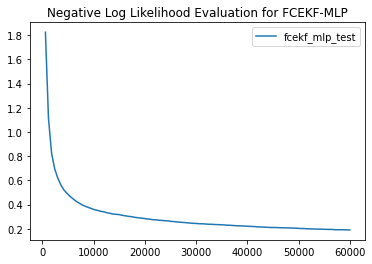

In [84]:
fig, ax = plt.subplots()
# ax.plot(x, result_fcekf[f'nll_train_per_{params_interval}_batches'], label='fcekf_mlp_train')
ax.plot(x, result_fcekf[f'nll_test_per_{params_interval}_batches'], label='fcekf_mlp_test')
ax.set_title('Negative Log Likelihood Evaluation for FCEKF-MLP')
ax.legend();

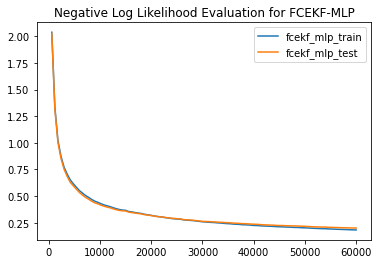

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_fcekf[f'nll_train_per_{params_interval}_batches'], label='fcekf_mlp_train')
ax.plot(x, result_fcekf[f'nll_test_per_{params_interval}_batches'], label='fcekf_mlp_test')
ax.set_title('Negative Log Likelihood Evaluation for FCEKF-MLP')
ax.legend();

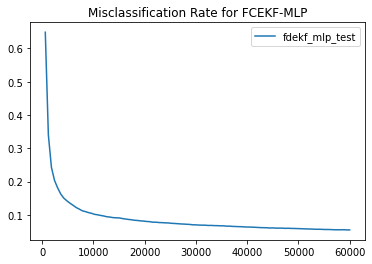

In [85]:
fig, ax = plt.subplots()
# ax.plot(x, result_fcekf[f'acc_train_per_{params_interval}_batches'], label='fdekf_mlp_train')
ax.plot(x, result_fcekf[f'acc_test_per_{params_interval}_batches'], label='fdekf_mlp_test')
ax.set_title('Misclassification Rate for FCEKF-MLP')
ax.legend();

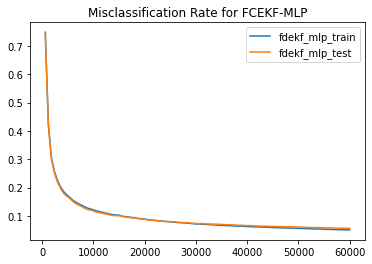

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_fcekf[f'acc_train_per_{params_interval}_batches'], label='fdekf_mlp_train')
ax.plot(x, result_fcekf[f'acc_test_per_{params_interval}_batches'], label='fdekf_mlp_test')
ax.set_title('Misclassification Rate for FCEKF-MLP')
ax.legend();

# 4. FDEKF

## 4.1 CNN

In [68]:
# Perform grid search on initial covariance
config = get_config()
grid_search_result_fdekf = {'nll': 1.0, 'init_var': 0.0}
init_vars = np.array([jnp.arange(9, 0, -0.5) * dec for dec in [1e-2]]).ravel()
for init_var in init_vars:
    print(f'Trying init_var={init_var:.5}...')
    config.init_var = init_var
    curr_nll = train_and_evaluate_ekf(train_tvsplit_ds, val_tvsplit_ds, config, 'fdekf', 
                                      immer_linearize=False, large_params=True,
                                      grid_search=True, params_interval=1000, 
                                      grid_search_size=5000)
    print(f'Current nll={curr_nll:.3f}\n')
    if curr_nll and curr_nll < grid_search_result_fdekf['nll']:
        grid_search_result_fdekf['nll'] = curr_nll
        grid_search_result_fdekf['init_var'] = init_var

Trying init_var=0.09...
Params size = (421642,)


test_nll = 0.2919468879699707: 100%|█████████▉| 4999/5000 [01:08<00:00, 73.38it/s] 


[DeviceArray(1.0179, dtype=float32), DeviceArray(0.4459, dtype=float32), DeviceArray(0.2744, dtype=float32), DeviceArray(0.3165, dtype=float32), DeviceArray(0.2919, dtype=float32)]
Current nll=0.469

Trying init_var=0.085...
Params size = (421642,)


test_nll = 0.3221520781517029: 100%|█████████▉| 4999/5000 [01:08<00:00, 73.44it/s] 


[DeviceArray(1.3829, dtype=float32), DeviceArray(0.3908, dtype=float32), DeviceArray(0.2686, dtype=float32), DeviceArray(0.3661, dtype=float32), DeviceArray(0.3222, dtype=float32)]
Current nll=0.546

Trying init_var=0.08...
Params size = (421642,)


test_nll = 0.30516889691352844: 100%|█████████▉| 4999/5000 [01:08<00:00, 73.38it/s] 


[DeviceArray(1.0388, dtype=float32), DeviceArray(0.4274, dtype=float32), DeviceArray(0.2839, dtype=float32), DeviceArray(0.3025, dtype=float32), DeviceArray(0.3052, dtype=float32)]
Current nll=0.472

Trying init_var=0.075...
Params size = (421642,)


test_nll = 0.272356778383255: 100%|█████████▉| 4999/5000 [01:07<00:00, 74.48it/s]  


[DeviceArray(0.8649, dtype=float32), DeviceArray(0.409, dtype=float32), DeviceArray(0.2987, dtype=float32), DeviceArray(0.2728, dtype=float32), DeviceArray(0.2724, dtype=float32)]
Current nll=0.424

Trying init_var=0.07...
Params size = (421642,)


test_nll = 0.25047728419303894: 100%|█████████▉| 4999/5000 [01:08<00:00, 73.49it/s] 


[DeviceArray(0.8934, dtype=float32), DeviceArray(0.3656, dtype=float32), DeviceArray(0.2745, dtype=float32), DeviceArray(0.2753, dtype=float32), DeviceArray(0.2505, dtype=float32)]
Current nll=0.412

Trying init_var=0.065...
Params size = (421642,)


test_nll = 0.24774861335754395: 100%|█████████▉| 4999/5000 [01:08<00:00, 72.50it/s] 


[DeviceArray(0.8341, dtype=float32), DeviceArray(0.3336, dtype=float32), DeviceArray(0.2682, dtype=float32), DeviceArray(0.3122, dtype=float32), DeviceArray(0.2477, dtype=float32)]
Current nll=0.399

Trying init_var=0.06...
Params size = (421642,)


test_nll = 0.23741593956947327: 100%|█████████▉| 4999/5000 [01:07<00:00, 73.66it/s] 


[DeviceArray(0.8591, dtype=float32), DeviceArray(0.3843, dtype=float32), DeviceArray(0.2661, dtype=float32), DeviceArray(0.3189, dtype=float32), DeviceArray(0.2374, dtype=float32)]
Current nll=0.413

Trying init_var=0.055...
Params size = (421642,)


test_nll = 0.2778802514076233: 100%|█████████▉| 4999/5000 [01:08<00:00, 72.74it/s]  


[DeviceArray(0.7717, dtype=float32), DeviceArray(0.3715, dtype=float32), DeviceArray(0.2563, dtype=float32), DeviceArray(0.304, dtype=float32), DeviceArray(0.2779, dtype=float32)]
Current nll=0.396

Trying init_var=0.05...
Params size = (421642,)


test_nll = 0.23118805885314941: 100%|█████████▉| 4999/5000 [01:08<00:00, 73.36it/s] 


[DeviceArray(0.7737, dtype=float32), DeviceArray(0.3485, dtype=float32), DeviceArray(0.2419, dtype=float32), DeviceArray(0.3005, dtype=float32), DeviceArray(0.2312, dtype=float32)]
Current nll=0.379

Trying init_var=0.045...
Params size = (421642,)


test_nll = 0.2438075989484787: 100%|█████████▉| 4999/5000 [01:07<00:00, 74.57it/s]  


[DeviceArray(0.7862, dtype=float32), DeviceArray(0.3576, dtype=float32), DeviceArray(0.2651, dtype=float32), DeviceArray(0.2654, dtype=float32), DeviceArray(0.2438, dtype=float32)]
Current nll=0.384

Trying init_var=0.04...
Params size = (421642,)


test_nll = 0.2350156307220459: 100%|█████████▉| 4999/5000 [01:07<00:00, 73.65it/s]  


[DeviceArray(0.7835, dtype=float32), DeviceArray(0.3615, dtype=float32), DeviceArray(0.2498, dtype=float32), DeviceArray(0.287, dtype=float32), DeviceArray(0.235, dtype=float32)]
Current nll=0.383

Trying init_var=0.035...
Params size = (421642,)


test_nll = 0.2297479212284088: 100%|█████████▉| 4999/5000 [01:08<00:00, 73.39it/s]  


[DeviceArray(0.7514, dtype=float32), DeviceArray(0.3369, dtype=float32), DeviceArray(0.251, dtype=float32), DeviceArray(0.2746, dtype=float32), DeviceArray(0.2297, dtype=float32)]
Current nll=0.369

Trying init_var=0.03...
Params size = (421642,)


test_nll = 0.25553789734840393: 100%|█████████▉| 4999/5000 [01:07<00:00, 74.60it/s] 


[DeviceArray(0.7084, dtype=float32), DeviceArray(0.3479, dtype=float32), DeviceArray(0.2587, dtype=float32), DeviceArray(0.2667, dtype=float32), DeviceArray(0.2555, dtype=float32)]
Current nll=0.367

Trying init_var=0.025...
Params size = (421642,)


test_nll = 0.2653510868549347: 100%|█████████▉| 4999/5000 [01:11<00:00, 70.08it/s]  


[DeviceArray(0.8589, dtype=float32), DeviceArray(0.3515, dtype=float32), DeviceArray(0.2646, dtype=float32), DeviceArray(0.266, dtype=float32), DeviceArray(0.2654, dtype=float32)]
Current nll=0.401

Trying init_var=0.02...
Params size = (421642,)


test_nll = 0.2764796316623688: 100%|█████████▉| 4999/5000 [01:09<00:00, 71.71it/s]  


[DeviceArray(0.8387, dtype=float32), DeviceArray(0.36, dtype=float32), DeviceArray(0.2872, dtype=float32), DeviceArray(0.2824, dtype=float32), DeviceArray(0.2765, dtype=float32)]
Current nll=0.409

Trying init_var=0.015...
Params size = (421642,)


test_nll = 0.30560892820358276: 100%|█████████▉| 4999/5000 [01:07<00:00, 73.64it/s] 


[DeviceArray(0.7829, dtype=float32), DeviceArray(0.3702, dtype=float32), DeviceArray(0.3157, dtype=float32), DeviceArray(0.2835, dtype=float32), DeviceArray(0.3056, dtype=float32)]
Current nll=0.412

Trying init_var=0.01...
Params size = (421642,)


test_nll = 0.35091447830200195: 100%|█████████▉| 4999/5000 [01:07<00:00, 74.17it/s] 


[DeviceArray(0.8408, dtype=float32), DeviceArray(0.3993, dtype=float32), DeviceArray(0.3532, dtype=float32), DeviceArray(0.3241, dtype=float32), DeviceArray(0.3509, dtype=float32)]
Current nll=0.454

Trying init_var=0.005...
Params size = (421642,)


test_nll = 0.4646203815937042: 100%|█████████▉| 4999/5000 [01:07<00:00, 73.89it/s]  

[DeviceArray(0.8145, dtype=float32), DeviceArray(0.446, dtype=float32), DeviceArray(0.4169, dtype=float32), DeviceArray(0.3845, dtype=float32), DeviceArray(0.4646, dtype=float32)]
Current nll=0.505



In [70]:
# Grid search result: init_var=3e-2
print(f'Grid search for FDEKF-CNN result: lr={grid_search_result_fdekf["init_var"]:.3f}')

Grid search for FDEKF-CNN result: lr=0.030


In [18]:
config = get_config()
config.init_var = 3e-2
state_fdekf_cnn, state_fdekf_param_cnn, result_fdekf_cnn = train_and_evaluate_ekf(train_ds, test_ds, config, 'fdekf', 
                                                                                  immer_linearize=False, large_params=True)

Params size = (421642,)


test_nll = 0.5461722612380981:   2%|▏         | 1199/60000 [00:30<25:14, 38.81it/s] 


KeyboardInterrupt: 

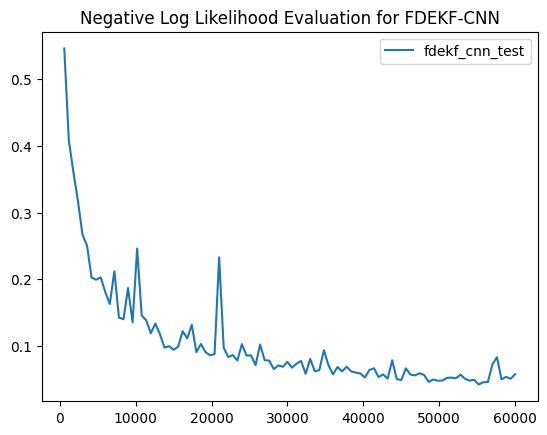

In [33]:
params_interval = 600
x = jnp.arange(params_interval, len(train_ds['image'])+1, params_interval)
fig, ax = plt.subplots()
# ax.plot(x, result_fdekf_cnn[f'nll_train_per_{params_interval}_batches'], label='fdekf_cnn_train')
ax.plot(x, result_fdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='fdekf_cnn_test')
ax.set_title('Negative Log Likelihood Evaluation for FDEKF-CNN')
ax.legend();

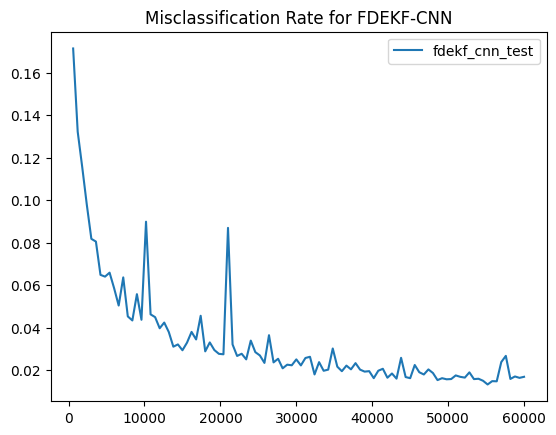

In [34]:
params_interval = 600
x = jnp.arange(params_interval, len(train_ds['image'])+1, params_interval)
fig, ax = plt.subplots()
# ax.plot(x, result_fdekf_cnn[f'nll_train_per_{params_interval}_batches'], label='fdekf_cnn_train')
ax.plot(x, result_fdekf_cnn[f'acc_test_per_{params_interval}_batches'], label='fdekf_cnn_test')
ax.set_title('Misclassification Rate for FDEKF-CNN')
ax.legend();

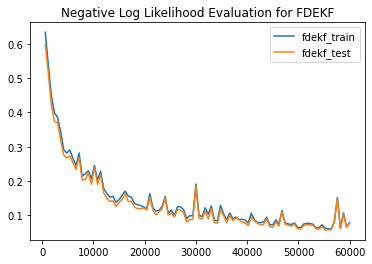

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_fdekf_cnn[f'nll_train_per_{params_interval}_batches'], label='fdekf_cnn_train')
ax.plot(x, result_fdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='fdekf_cnn_test')
ax.set_title('Negative Log Likelihood Evaluation for FDEKF-CNN')
ax.legend();

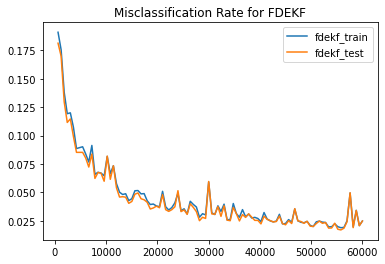

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_fdekf_cnn[f'acc_train_per_{params_interval}_batches'], label='fdekf_cnn_train')
ax.plot(x, result_fdekf_cnn[f'acc_test_per_{params_interval}_batches'], label='fdekf_cnn_test')
ax.set_title('Misclassification Rate for FDEKF-CNN')
ax.legend();

## 4.1.2 CNN - Focus on the first 5000

In [75]:
config = get_config()
config.init_var = 3e-2
state_fdekf_partial_cnn, state_fdekf_param_partial_cnn, result_fdekf_partial_cnn = train_and_evaluate_ekf(train_partial_ds, test_ds, config, 'fdekf', 
                                                                                  immer_linearize=False, large_params=True,
                                                                                  params_interval=10)

Params size = (421642,)


test_nll = 0.31061866879463196: 100%|██████████| 5000/5000 [48:42<00:00,  1.71it/s]


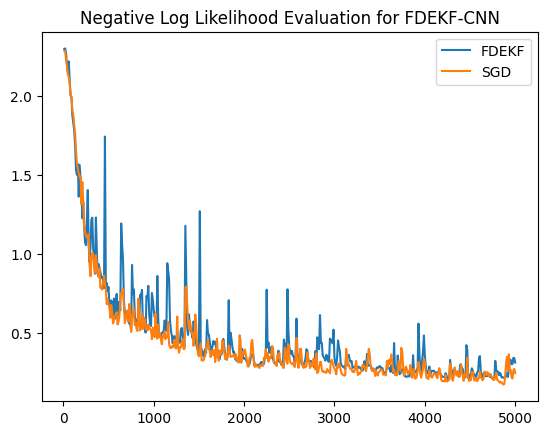

In [113]:
params_interval = 10
x = jnp.arange(params_interval, len(train_partial_ds['image'])+1, params_interval)
fig, ax = plt.subplots()
ax.plot(x, result_fdekf_partial_cnn[f'nll_test_per_{params_interval}_batches'], label='FDEKF')
plt.plot(x, y_nll_sgd_partial_test, label='SGD')
ax.set_title('Negative Log Likelihood Evaluation for FDEKF-CNN')
ax.legend();

## 4.1.3 CNN - First 5000 - MAP

In [119]:
config = get_config()
config.init_var = 3e-2
state_fdekf_partial_map_cnn, state_fdekf_param_partial_map_cnn, result_fdekf_partial_map_cnn = \
    train_and_evaluate_ekf(train_partial_ds, test_ds, config, 'fdekf', immer_linearize=False,
                            params_interval=10, map_estimate=True)

Params size = (421642,)


test_nll = 0.951018214225769:   7%|▋         | 339/5000 [06:11<1:25:13,  1.10s/it] 


KeyboardInterrupt: 

## 4.2 MLP

In [ ]:
features = [25, 25, 25, 10]

# Perform grid search on initial covariance
config = get_config()
grid_search_result_fdekf_mlp = {'nll': 1.0, 'init_var': 0.0}
init_vars = np.array([jnp.arange(9, 0, -1) * dec for dec in [1e-1, 1e-2, 1e-3]]).ravel()
for init_var in init_vars:
    print(f'Trying init_var={init_var:.5}...')
    config.init_var = init_var
    curr_nll = train_and_evaluate_ekf(train_tvsplit_ds, val_tvsplit_ds, config, 'fdekf', features=features,
                                      train_with_MLP=True, grid_search=True, params_interval=2000)
    print(f'Current nll={curr_nll:.3f}\n')
    if curr_nll and curr_nll < grid_search_result_fdekf_mlp['nll']:
        grid_search_result_fdekf_mlp['nll'] = curr_nll
        grid_search_result_fdekf_mlp['init_var'] = init_var

In [ ]:
# Grid search result: init_var=9e-2
print(f'Grid search for FDEKF-MLP result: lr={grid_search_result_fdekf_mlp["init_var"]:.3f}')

In [86]:
features = [25, 25, 25, 10]
state_fdekf_mlp, state_param_fdekf_mlp, result_fdekf_mlp = train_and_evaluate_ekf(train_ds, test_ds, config, 'fdekf', train_with_MLP=True, features=features)

Params size = (21185,)


test_nll = 0.19664523005485535: 100%|██████████| 60000/60000 [06:19<00:00, 158.18it/s]


In [87]:
params_interval = 600
x = jnp.arange(params_interval, len(train_ds['image'])+1, params_interval)

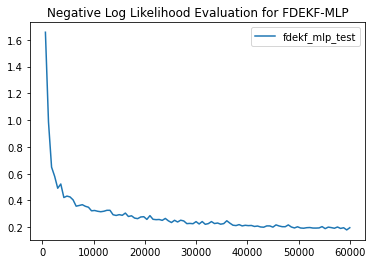

In [88]:
fig, ax = plt.subplots()
ax.plot(x, result_fdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='fdekf_mlp_test')
ax.set_title('Negative Log Likelihood Evaluation for FDEKF-MLP')
ax.legend();

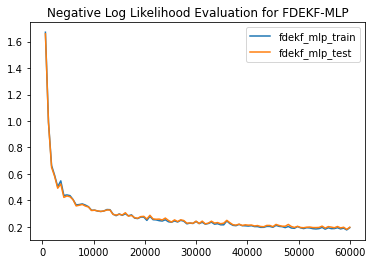

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_fdekf_mlp[f'nll_train_per_{params_interval}_batches'], label='fdekf_mlp_train')
ax.plot(x, result_fdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='fdekf_mlp_test')
ax.set_title('Negative Log Likelihood Evaluation for FDEKF-MLP')
ax.legend();

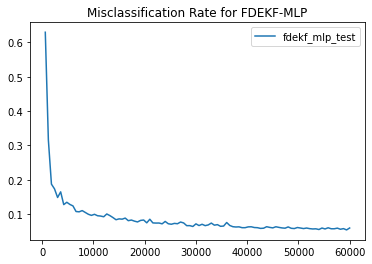

In [89]:
fig, ax = plt.subplots()
# ax.plot(x, result_fdekf_mlp[f'acc_train_per_{params_interval}_batches'], label='fdekf_mlp_train')
ax.plot(x, result_fdekf_mlp[f'acc_test_per_{params_interval}_batches'], label='fdekf_mlp_test')
ax.set_title('Misclassification Rate for FDEKF-MLP')
ax.legend();

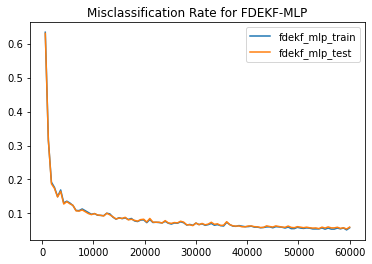

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_fdekf_mlp[f'acc_train_per_{params_interval}_batches'], label='fdekf_mlp_train')
ax.plot(x, result_fdekf_mlp[f'acc_test_per_{params_interval}_batches'], label='fdekf_mlp_test')
ax.set_title('Misclassification Rate for FDEKF-MLP')
ax.legend();

# 6. VDEKF

## 6.1 CNN

In [69]:
# Perform grid search on initial covariance
config = get_config()
grid_search_result_vdekf = {'nll': 1.0, 'init_var': 0.0}
init_vars = np.array([jnp.arange(9, 0, -0.5) * dec for dec in [1e-2]]).ravel()
for init_var in init_vars:
    print(f'Trying init_var={init_var:.5}...')
    config.init_var = init_var
    curr_nll = train_and_evaluate_ekf(train_tvsplit_ds, val_tvsplit_ds, config, 'vdekf', 
                                      immer_linearize=False, large_params=True,
                                      grid_search=True, params_interval=1000,
                                      grid_search_size=5000)
    print(f'Current nll={curr_nll:.3f}\n')
    if curr_nll and curr_nll < grid_search_result_vdekf['nll']:
        grid_search_result_vdekf['nll'] = curr_nll
        grid_search_result_vdekf['init_var'] = init_var

Trying init_var=0.09...
Params size = (421642,)


test_nll = 0.20115253329277039: 100%|█████████▉| 4999/5000 [01:09<00:00, 71.96it/s] 


[DeviceArray(0.704, dtype=float32), DeviceArray(0.2504, dtype=float32), DeviceArray(0.1845, dtype=float32), DeviceArray(0.1727, dtype=float32), DeviceArray(0.2012, dtype=float32)]
Current nll=0.303

Trying init_var=0.085...
Params size = (421642,)


test_nll = 0.182332381606102: 100%|█████████▉| 4999/5000 [01:09<00:00, 72.37it/s]   


[DeviceArray(0.6975, dtype=float32), DeviceArray(0.2468, dtype=float32), DeviceArray(0.2115, dtype=float32), DeviceArray(0.1936, dtype=float32), DeviceArray(0.1823, dtype=float32)]
Current nll=0.306

Trying init_var=0.08...
Params size = (421642,)


test_nll = 0.17459319531917572: 100%|█████████▉| 4999/5000 [01:09<00:00, 71.74it/s] 


[DeviceArray(0.5771, dtype=float32), DeviceArray(0.2912, dtype=float32), DeviceArray(0.2074, dtype=float32), DeviceArray(0.1891, dtype=float32), DeviceArray(0.1746, dtype=float32)]
Current nll=0.288

Trying init_var=0.075...
Params size = (421642,)


test_nll = 0.19388268887996674: 100%|█████████▉| 4999/5000 [01:10<00:00, 71.16it/s] 


[DeviceArray(0.6765, dtype=float32), DeviceArray(0.2591, dtype=float32), DeviceArray(0.1644, dtype=float32), DeviceArray(0.1589, dtype=float32), DeviceArray(0.1939, dtype=float32)]
Current nll=0.291

Trying init_var=0.07...
Params size = (421642,)


test_nll = 0.16419199109077454: 100%|█████████▉| 4999/5000 [01:08<00:00, 73.18it/s] 


[DeviceArray(0.5376, dtype=float32), DeviceArray(0.2481, dtype=float32), DeviceArray(0.1933, dtype=float32), DeviceArray(0.1892, dtype=float32), DeviceArray(0.1642, dtype=float32)]
Current nll=0.266

Trying init_var=0.065...
Params size = (421642,)


test_nll = 0.1755090057849884: 100%|█████████▉| 4999/5000 [01:10<00:00, 70.63it/s]  


[DeviceArray(0.5329, dtype=float32), DeviceArray(0.2248, dtype=float32), DeviceArray(0.1765, dtype=float32), DeviceArray(0.1685, dtype=float32), DeviceArray(0.1755, dtype=float32)]
Current nll=0.256

Trying init_var=0.06...
Params size = (421642,)


test_nll = 0.1724940836429596: 100%|█████████▉| 4999/5000 [01:09<00:00, 71.65it/s]  


[DeviceArray(0.6964, dtype=float32), DeviceArray(0.235, dtype=float32), DeviceArray(0.1721, dtype=float32), DeviceArray(0.1562, dtype=float32), DeviceArray(0.1725, dtype=float32)]
Current nll=0.286

Trying init_var=0.055...
Params size = (421642,)


test_nll = 0.18284721672534943: 100%|█████████▉| 4999/5000 [01:08<00:00, 72.60it/s] 


[DeviceArray(0.5679, dtype=float32), DeviceArray(0.222, dtype=float32), DeviceArray(0.1859, dtype=float32), DeviceArray(0.1605, dtype=float32), DeviceArray(0.1828, dtype=float32)]
Current nll=0.264

Trying init_var=0.05...
Params size = (421642,)


test_nll = 0.18516282737255096: 100%|█████████▉| 4999/5000 [01:12<00:00, 68.84it/s] 


[DeviceArray(0.5734, dtype=float32), DeviceArray(0.2351, dtype=float32), DeviceArray(0.196, dtype=float32), DeviceArray(0.1814, dtype=float32), DeviceArray(0.1852, dtype=float32)]
Current nll=0.274

Trying init_var=0.045...
Params size = (421642,)


test_nll = 0.17899291217327118: 100%|█████████▉| 4999/5000 [01:10<00:00, 70.43it/s] 


[DeviceArray(0.6308, dtype=float32), DeviceArray(0.217, dtype=float32), DeviceArray(0.2057, dtype=float32), DeviceArray(0.1604, dtype=float32), DeviceArray(0.179, dtype=float32)]
Current nll=0.279

Trying init_var=0.04...
Params size = (421642,)


test_nll = 0.18672554194927216: 100%|█████████▉| 4999/5000 [01:09<00:00, 72.40it/s] 


[DeviceArray(0.6023, dtype=float32), DeviceArray(0.2293, dtype=float32), DeviceArray(0.1966, dtype=float32), DeviceArray(0.1725, dtype=float32), DeviceArray(0.1867, dtype=float32)]
Current nll=0.277

Trying init_var=0.035...
Params size = (421642,)


test_nll = 0.19816605746746063: 100%|█████████▉| 4999/5000 [01:10<00:00, 71.21it/s] 


[DeviceArray(0.5787, dtype=float32), DeviceArray(0.2367, dtype=float32), DeviceArray(0.1923, dtype=float32), DeviceArray(0.1673, dtype=float32), DeviceArray(0.1982, dtype=float32)]
Current nll=0.275

Trying init_var=0.03...
Params size = (421642,)


test_nll = 0.20156677067279816: 100%|█████████▉| 4999/5000 [01:09<00:00, 72.09it/s] 


[DeviceArray(0.5905, dtype=float32), DeviceArray(0.2605, dtype=float32), DeviceArray(0.2124, dtype=float32), DeviceArray(0.1726, dtype=float32), DeviceArray(0.2016, dtype=float32)]
Current nll=0.288

Trying init_var=0.025...
Params size = (421642,)


test_nll = 0.20003795623779297: 100%|█████████▉| 4999/5000 [01:08<00:00, 72.93it/s] 


[DeviceArray(0.6607, dtype=float32), DeviceArray(0.2738, dtype=float32), DeviceArray(0.2224, dtype=float32), DeviceArray(0.1921, dtype=float32), DeviceArray(0.2, dtype=float32)]
Current nll=0.310

Trying init_var=0.02...
Params size = (421642,)


test_nll = 0.21875832974910736: 100%|█████████▉| 4999/5000 [01:10<00:00, 71.05it/s] 


[DeviceArray(0.6816, dtype=float32), DeviceArray(0.2888, dtype=float32), DeviceArray(0.2487, dtype=float32), DeviceArray(0.1917, dtype=float32), DeviceArray(0.2188, dtype=float32)]
Current nll=0.326

Trying init_var=0.015...
Params size = (421642,)


test_nll = 0.2279810905456543: 100%|█████████▉| 4999/5000 [01:09<00:00, 71.74it/s]  


[DeviceArray(0.7189, dtype=float32), DeviceArray(0.3059, dtype=float32), DeviceArray(0.2856, dtype=float32), DeviceArray(0.2146, dtype=float32), DeviceArray(0.228, dtype=float32)]
Current nll=0.351

Trying init_var=0.01...
Params size = (421642,)


test_nll = 0.2600409984588623: 100%|█████████▉| 4999/5000 [01:12<00:00, 69.02it/s]  


[DeviceArray(0.7893, dtype=float32), DeviceArray(0.3452, dtype=float32), DeviceArray(0.3015, dtype=float32), DeviceArray(0.239, dtype=float32), DeviceArray(0.26, dtype=float32)]
Current nll=0.387

Trying init_var=0.005...
Params size = (421642,)


test_nll = 0.41273200511932373: 100%|█████████▉| 4999/5000 [01:12<00:00, 69.29it/s] 

[DeviceArray(0.8058, dtype=float32), DeviceArray(0.4085, dtype=float32), DeviceArray(0.3853, dtype=float32), DeviceArray(0.3165, dtype=float32), DeviceArray(0.4127, dtype=float32)]
Current nll=0.466



In [71]:
# Grid search result: init_var=6.5e-2
print(f'Grid search for VDEKF-CNN result: lr={grid_search_result_vdekf["init_var"]:.3f}')

Grid search for VDEKF-CNN result: lr=0.065


In [35]:
config = get_config()
config.init_var = 6.5e-2
state_vdekf_cnn, state_vdekf_param_cnn, result_vdekf_cnn = train_and_evaluate_ekf(train_ds, test_ds, config, 'vdekf', immer_linearize=False, large_params=True)

Params size = (421642,)


test_nll = 0.036805421113967896: 100%|██████████| 60000/60000 [13:33<00:00, 73.71it/s] 


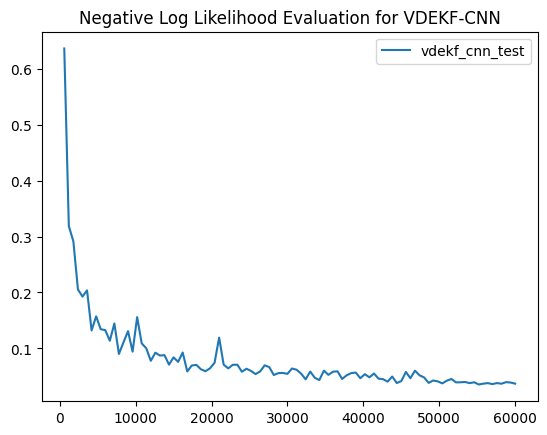

In [36]:
fig, ax = plt.subplots()
# ax.plot(x, result_vdekf_cnn[f'nll_train_per_{params_interval}_batches'], label='vdekf_cnn_train')
ax.plot(x, result_vdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='vdekf_cnn_test')
ax.set_title('Negative Log Likelihood Evaluation for VDEKF-CNN')
ax.legend();

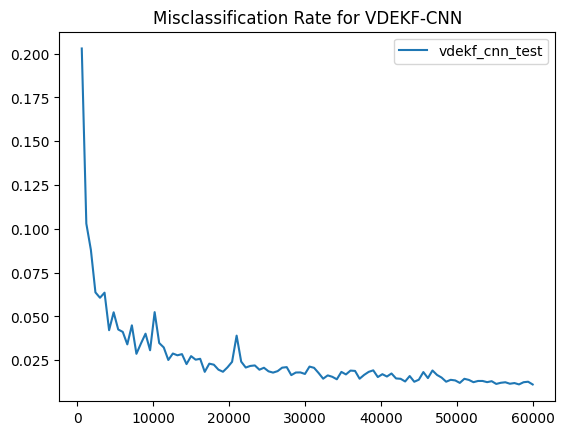

In [37]:
fig, ax = plt.subplots()
ax.plot(x, result_vdekf_cnn[f'acc_test_per_{params_interval}_batches'], label='vdekf_cnn_test')
ax.set_title('Misclassification Rate for VDEKF-CNN')
ax.legend();

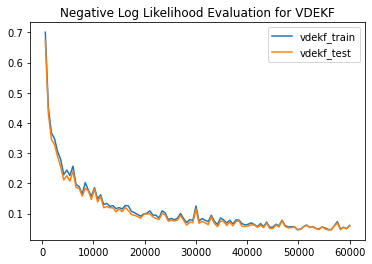

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_vdekf_cnn[f'nll_train_per_{params_interval}_batches'], label='vdekf_cnn_train')
ax.plot(x, result_vdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='vdekf_cnn_test')
ax.set_title('Negative Log Likelihood Evaluation for VDEKF-CNN')
ax.legend();

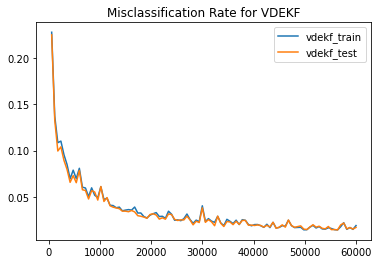

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_vdekf_cnn[f'acc_train_per_{params_interval}_batches'], label='vdekf_cnn_train')
ax.plot(x, result_vdekf_cnn[f'acc_test_per_{params_interval}_batches'], label='vdekf_cnn_test')
ax.set_title('Misclassification Rate for VDEKF-CNN')
ax.legend();

## 6.1.2 CNN - Focus on the first 5000

In [83]:
config = get_config()
config.init_var = 6.5e-2
state_vdekf_partial_cnn, state_vdekf_param_partial_cnn, result_vdekf_partial_cnn = train_and_evaluate_ekf(train_partial_ds, 
                                                                                  test_ds, config, 'vdekf', 
                                                                                  immer_linearize=False, large_params=True,
                                                                                  params_interval=10)

Params size = (421642,)


test_nll = 0.18034832179546356: 100%|██████████| 5000/5000 [48:44<00:00,  1.71it/s]


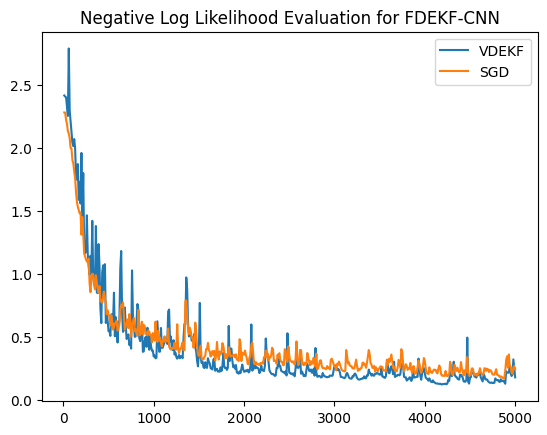

In [84]:
params_interval = 10
x = jnp.arange(params_interval, len(train_partial_ds['image'])+1, params_interval)
fig, ax = plt.subplots()
ax.plot(x, result_vdekf_partial_cnn[f'nll_test_per_{params_interval}_batches'], label='VDEKF')
plt.plot(x, y_nll_sgd_partial_test, label='SGD')
ax.set_title('Negative Log Likelihood Evaluation for FDEKF-CNN')
ax.legend();

## 6.2 MLP

In [ ]:
features = [25, 25, 25, 10]

# Perform grid search on initial covariance
config = get_config()
grid_search_result_vdekf = {'nll': 1.0, 'init_var': 0.0}
init_vars = np.array([jnp.arange(9, 0, -1) * dec for dec in [1e-1, 1e-2, 1e-3]]).ravel()
for init_var in init_vars:
    print(f'Trying init_var={init_var:.5}...')
    config.init_var = init_var
    curr_nll = train_and_evaluate_ekf(train_tvsplit_ds, val_tvsplit_ds, config, 'vdekf', features=features,
                                      train_with_MLP=True, grid_search=True, params_interval=2000)
    print(f'Current nll={curr_nll:.3f}\n')
    if curr_nll and curr_nll < grid_search_result_vdekf['nll']:
        grid_search_result_vdekf['nll'] = curr_nll
        grid_search_result_vdekf['init_var'] = init_var

In [ ]:
# Grid search result: init_var=9e-2
print(f'Grid search for VDEKF-MLP result: lr={grid_search_result_vdekf["init_var"]:.3f}')

In [90]:
state_vdekf_mlp, state_param_vdekf_mlp, result_vdekf_mlp = train_and_evaluate_ekf(train_ds, test_ds, config, 'vdekf', train_with_MLP=True, features=features)

Params size = (21185,)


test_nll = 0.1918712556362152: 100%|██████████| 60000/60000 [06:16<00:00, 159.29it/s]


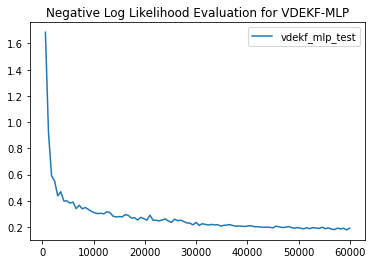

In [91]:
fig, ax = plt.subplots()
# ax.plot(x, result_vdekf_mlp[f'nll_train_per_{params_interval}_batches'], label='vdekf_mlp_train')
ax.plot(x, result_vdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='vdekf_mlp_test')
ax.set_title('Negative Log Likelihood Evaluation for VDEKF-MLP')
ax.legend();

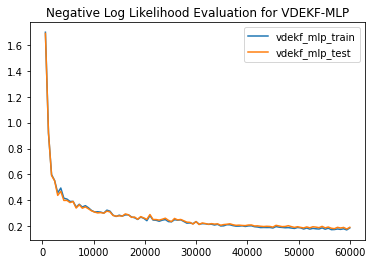

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_vdekf_mlp[f'nll_train_per_{params_interval}_batches'], label='vdekf_mlp_train')
ax.plot(x, result_vdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='vdekf_mlp_test')
ax.set_title('Negative Log Likelihood Evaluation for VDEKF-MLP')
ax.legend();

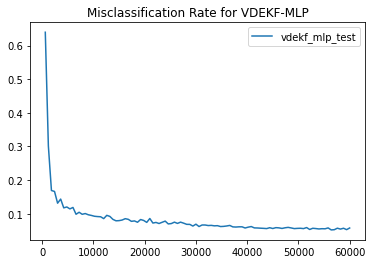

In [92]:
fig, ax = plt.subplots()
# ax.plot(x, result_vdekf_mlp[f'acc_train_per_{params_interval}_batches'], label='vdekf_mlp_train')
ax.plot(x, result_vdekf_mlp[f'acc_test_per_{params_interval}_batches'], label='vdekf_mlp_test')
ax.set_title('Misclassification Rate for VDEKF-MLP')
ax.legend();

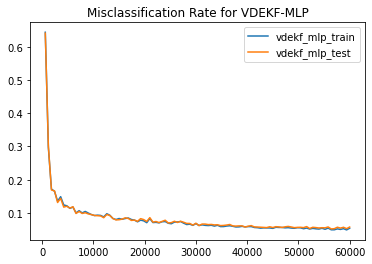

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, result_vdekf_mlp[f'acc_train_per_{params_interval}_batches'], label='vdekf_mlp_train')
ax.plot(x, result_vdekf_mlp[f'acc_test_per_{params_interval}_batches'], label='vdekf_mlp_test')
ax.set_title('Misclassification Rate for VDEKF-MLP')
ax.legend();

# 7. Model Efficiency Comparison

## 7.1 CNN: SGD vs FDEKF vs VDEKF

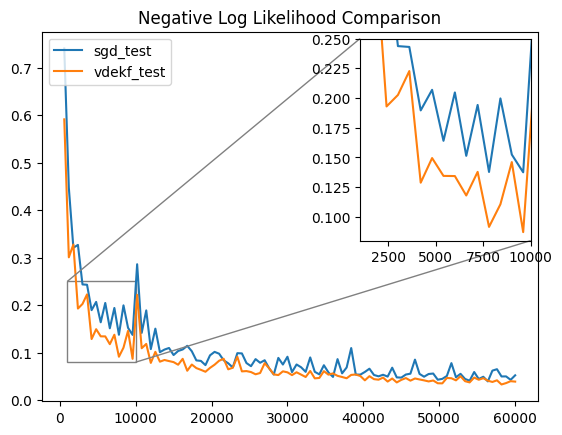

In [159]:
fig, ax = plt.subplots()
ax.plot(x, y_nll_sgd_test, label='sgd_test')
# ax.plot(x, result_fdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='fdekf_test')
ax.plot(x, result_vdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='vdekf_test')
ax.set_title('MNIST Negative Log Likelihood Comparison (CNN)')
ax.legend(loc=2);
axins = zoomed_inset_axes(ax, 2.5, loc=1)
axins.plot(x, y_nll_sgd_test, label='sgd_test')
# axins.plot(x, result_fdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='fdekf_test')
axins.plot(x, result_vdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='vdekf_test')
axins.set_xlim(1000, 10000)
axins.set_ylim(0.08, 0.25)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
fig.savefig('nll_comparison.jpg')

NameError: name 'y_nll_sgd_test' is not defined

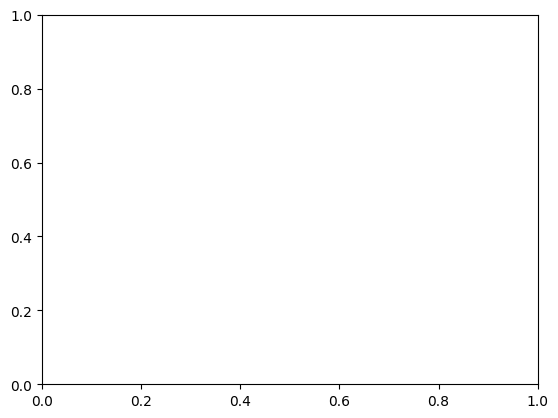

In [88]:
fig, ax = plt.subplots()
ax.plot(x, y_nll_sgd_test, label='sgd_test')
ax.plot(x, result_fdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='fdekf_test')
ax.plot(x, result_vdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='vdekf_test')
ax.set_title('MNIST Negative Log Likelihood Comparison (CNN)')
ax.legend(loc=2);
axins = zoomed_inset_axes(ax, 2.5, loc=1)
axins.plot(x, y_nll_sgd_test, label='sgd_test')
axins.plot(x, result_fdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='fdekf_test')
axins.plot(x, result_vdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='vdekf_test')
axins.set_xlim(1000, 10000)
axins.set_ylim(0.08, 0.25)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
fig.savefig('nll_comparison.jpg')

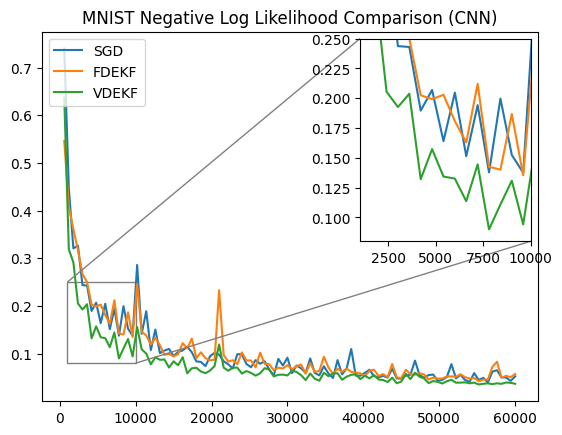

In [43]:
params_interval = 600
x = jnp.arange(params_interval, len(train_ds['image'])+1, params_interval)
fig, ax = plt.subplots()
ax.plot(x, y_nll_sgd_test, label='SGD')
ax.plot(x, result_fdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='FDEKF')
ax.plot(x, result_vdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='VDEKF')
ax.set_title('MNIST Negative Log Likelihood Comparison (CNN)')
ax.legend(loc=2);
axins = zoomed_inset_axes(ax, 2.5, loc=1)
axins.plot(x, y_nll_sgd_test, label='SGD')
axins.plot(x, result_fdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='FDEKF')
axins.plot(x, result_vdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='VDEKF')
axins.set_xlim(1000, 10000)
axins.set_ylim(0.08, 0.25)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
fig.savefig('nll_comparison_cnn.jpg')

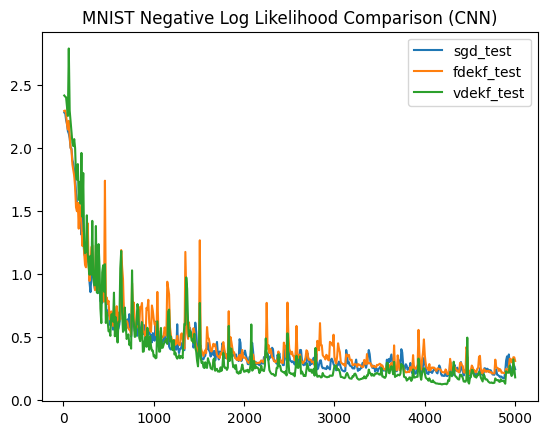

In [87]:
fig, ax = plt.subplots()
ax.plot(x, y_nll_sgd_partial_test, label='sgd_test')
ax.plot(x, result_fdekf_partial_cnn[f'nll_test_per_{params_interval}_batches'], label='fdekf_test')
ax.plot(x, result_vdekf_partial_cnn[f'nll_test_per_{params_interval}_batches'], label='vdekf_test')
ax.set_title('MNIST Negative Log Likelihood Comparison (CNN)')
ax.legend()
fig.savefig('nll_comparison.jpg')

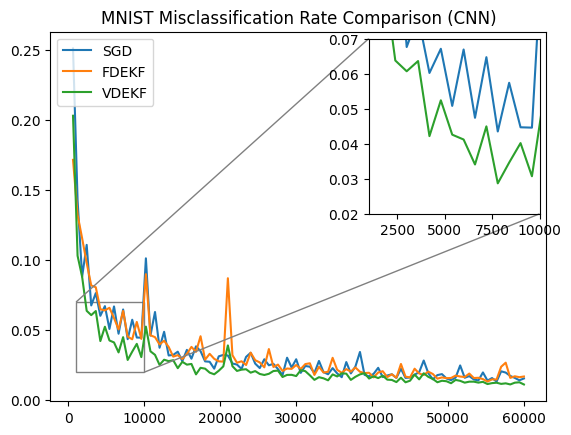

In [44]:
fig, ax = plt.subplots()
ax.plot(x, y_acc_sgd_test, label='SGD')
ax.plot(x, result_fdekf_cnn[f'acc_test_per_{params_interval}_batches'], label='FDEKF')
ax.plot(x, result_vdekf_cnn[f'acc_test_per_{params_interval}_batches'], label='VDEKF')
ax.set_title('MNIST Misclassification Rate Comparison (CNN)')
ax.legend(loc=2);
axins = zoomed_inset_axes(ax, 2.5, loc=1)
axins.plot(x, y_acc_sgd_test, label='SGD')
axins.plot(x, result_fdekf_cnn[f'nll_test_per_{params_interval}_batches'], label='FDEKF')
axins.plot(x, result_vdekf_cnn[f'acc_test_per_{params_interval}_batches'], label='VDEKF')
axins.set_xlim(1000, 10000)
axins.set_ylim(0.02, 0.07)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
fig.savefig('acc_comparison_cnn.jpg')

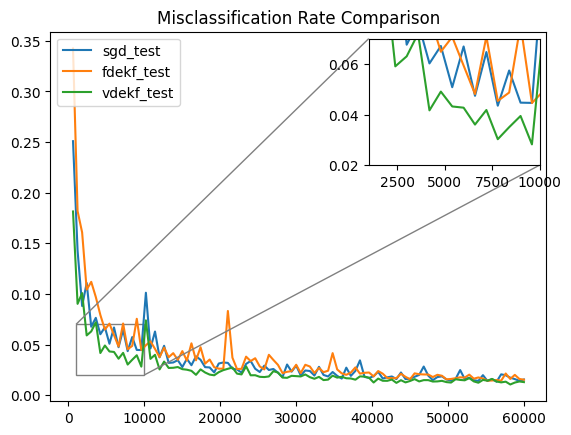

In [166]:
fig, ax = plt.subplots()
ax.plot(x, y_acc_sgd_test, label='sgd_test')
ax.plot(x, result_fdekf_cnn[f'acc_test_per_{params_interval}_batches'], label='fdekf_test')
ax.plot(x, result_vdekf_cnn[f'acc_test_per_{params_interval}_batches'], label='vdekf_test')
ax.set_title('MNIST Misclassification Rate Comparison (CNN)')
ax.legend(loc=2);
axins = zoomed_inset_axes(ax, 2.5, loc=1)
axins.plot(x, y_acc_sgd_test, label='sgd_test')
axins.plot(x, result_fdekf_cnn[f'acc_test_per_{params_interval}_batches'], label='fdekf_test')
axins.plot(x, result_vdekf_cnn[f'acc_test_per_{params_interval}_batches'], label='vdekf_test')
axins.set_xlim(1000, 10000)
axins.set_ylim(0.02, 0.07)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
fig.savefig('acc_comparison.jpg')

## 7.2 MLP: SGD vs FCEKF vs FDEKF vs VDEKF

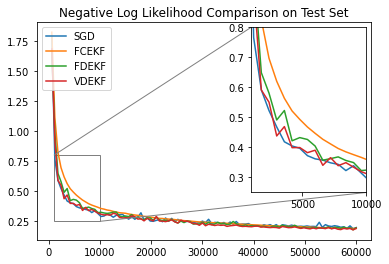

In [114]:
fig, ax = plt.subplots()
ax.plot(x, y_nll_sgd_mlp_polyak_test, label='SGD')
ax.plot(x, result_fcekf[f'nll_test_per_{params_interval}_batches'], label='FCEKF')
ax.plot(x, result_fdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='FDEKF')
ax.plot(x, result_vdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='VDEKF')
ax.set_title('Negative Log Likelihood Comparison on Test Set')
ax.legend(loc=2);
axins = zoomed_inset_axes(ax, 2.5, loc=1)
axins.plot(x, y_nll_sgd_mlp_polyak_test, label='sgd_mlp_test')
axins.plot(x, result_fcekf[f'nll_test_per_{params_interval}_batches'], label='fcekf_mlp_test')
axins.plot(x, result_fdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='fdekf_mlp_test')
axins.plot(x, result_vdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='vdekf_mlp_test')
axins.set_xlim(1000, 10000)
axins.set_ylim(0.25, 0.8)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
fig.savefig('nll_comparison_mlp.jpg')

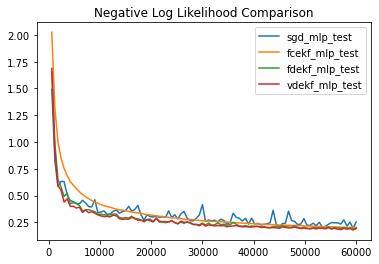

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y_nll_sgd_mlp_test, label='sgd_mlp_test')
ax.plot(x, result_fcekf[f'nll_test_per_{params_interval}_batches'], label='fcekf_mlp_test')
ax.plot(x, result_fdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='fdekf_mlp_test')
ax.plot(x, result_vdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='vdekf_mlp_test')
ax.set_title('Negative Log Likelihood Comparison')
ax.legend();
fig.savefig('nll_comparison.jpg')

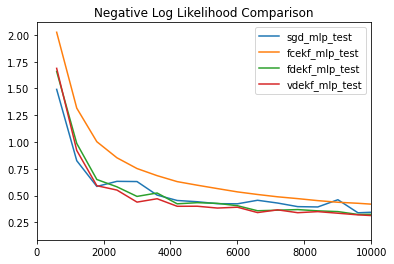

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y_nll_sgd_mlp_test, label='sgd_mlp_test')
ax.plot(x, result_fcekf[f'nll_test_per_{params_interval}_batches'], label='fcekf_mlp_test')
ax.plot(x, result_fdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='fdekf_mlp_test')
ax.plot(x, result_vdekf_mlp[f'nll_test_per_{params_interval}_batches'], label='vdekf_mlp_test')
ax.set_title('Negative Log Likelihood Comparison')
ax.set_xlim(0, 10000)
ax.legend();
fig.savefig('nll_comparison_zoomed.jpg')

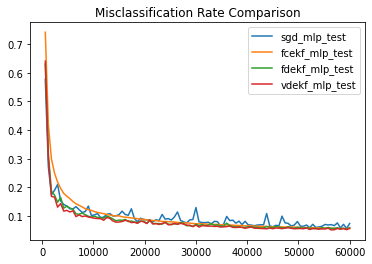

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y_acc_sgd_mlp_test, label='sgd_mlp_test')
ax.plot(x, result_fcekf[f'acc_test_per_{params_interval}_batches'], label='fcekf_mlp_test')
ax.plot(x, result_fdekf_mlp[f'acc_test_per_{params_interval}_batches'], label='fdekf_mlp_test')
ax.plot(x, result_vdekf_mlp[f'acc_test_per_{params_interval}_batches'], label='vdekf_mlp_test')
ax.set_title('Misclassification Rate Comparison')
ax.legend();
fig.savefig('acc_comparison.jpg')

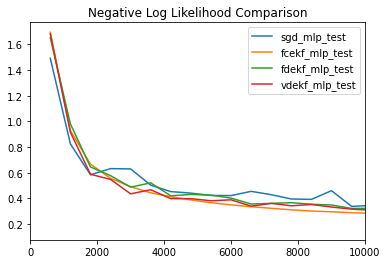

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y_nll_sgd_mlp_test, label='sgd_mlp_test')
ax.plot(x, y_nll_fcekf_test, label='fcekf_mlp_test')
ax.plot(x, y_nll_fdekf_mlp_test, label='fdekf_mlp_test')
ax.plot(x, y_nll_vdekf_mlp_test, label='vdekf_mlp_test')
ax.set_title('Negative Log Likelihood Comparison')
ax.set_xlim(0, 10000)
ax.legend();
fig.savefig('nll_comparison.jpg')

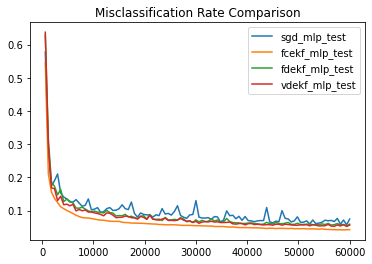

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y_acc_sgd_mlp_test, label='sgd_mlp_test')
ax.plot(x, y_acc_fcekf_test, label='fcekf_mlp_test')
ax.plot(x, y_acc_fdekf_mlp_test, label='fdekf_mlp_test')
ax.plot(x, y_acc_vdekf_mlp_test, label='vdekf_mlp_test')
ax.set_title('Misclassification Rate Comparison')
ax.legend();
fig.savefig('acc_comparison.jpg')

# 8. Fashion-MNIST

In [19]:
def get_fashion_mnist_datasets():
    """Load Fashion-MNIST train and test datasets into memory."""
    ds_builder = tfds.builder('fashion_mnist')
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
    train_ds['image'] = jnp.float32(train_ds['image']) / 255.
    test_ds['image'] = jnp.float32(test_ds['image']) / 255.
    return train_ds, test_ds
    
train_ds_fashion, test_ds_fashion = get_fashion_mnist_datasets()

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:  25%|██▌       | 1/4 [00:00<00:00,  3.09 url/s]

Dl Completed...:  50%|█████     | 2/4 [00:00<00:00,  5.02 url/s]

Dl Completed...:  75%|███████▌  | 3/4 [00:01<00:00,  2.20 url/s]

Dl Completed...: 100%|██████████| 4/4 [00:02<00:00,  1.57 url/s]

Dl Completed...: 100%|██████████| 4/4 [00:02<00:00,  1.61 url/s]


Dataset fashion_mnist downloaded and prepared to /home/peter0414/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


## 8.1 SGD

In [20]:
# SGD
config = get_config(learning_rate=0.01, momentum=0.2)
state_sgd_fashion, result_sgd_fashion = train_and_evaluate_sgd(train_ds_fashion, config)

loss-scaled mean accuracy: 0.774; mean accuracy: 0.918: 100%|██████████| 60000/60000 [03:19<00:00, 300.56it/s]


In [21]:
params_interval = 600
x = jnp.arange(params_interval, len(train_ds['image'])+1, params_interval)
y_nll_sgd_fashion_test = []
y_nll_sgd_fashion_train = []
for i, param in enumerate(tqdm(result_sgd_fashion[f'param_per_{params_interval}_batches'])):
    # Evaluate nll on test set
    y_nll_sgd_fashion_test.append(evaluate_neg_log_likelihood(state_sgd_fashion, param, test_ds_fashion))

    # Evaluate nll on train set
    y_nll_sgd_fashion_train.append(evaluate_neg_log_likelihood(state_sgd_fashion, param, train_ds_fashion))

100%|██████████| 100/100 [00:28<00:00,  3.48it/s]


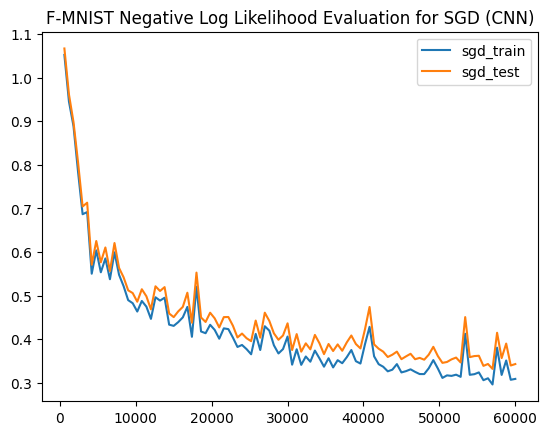

In [22]:
plt.plot(x, y_nll_sgd_fashion_train, label='sgd_train')
plt.plot(x, y_nll_sgd_fashion_test, label='sgd_test')
plt.title('F-MNIST Negative Log Likelihood Evaluation for SGD (CNN)')
plt.legend();

In [23]:
y_acc_sgd_fashion_test = []
y_acc_sgd_fashion_train = []
for i, param in enumerate(tqdm(result_sgd_fashion[f'param_per_{params_interval}_batches'])):
    # Evaluate misclassification rate on test set
    y_acc_sgd_fashion_test.append(evaluate_accuracy(state_sgd_fashion, param, test_ds_fashion))

    # Evaluate misclassification rate on train set
    y_acc_sgd_fashion_train.append(evaluate_accuracy(state_sgd_fashion, param, train_ds_fashion))

100%|██████████| 100/100 [00:28<00:00,  3.52it/s]


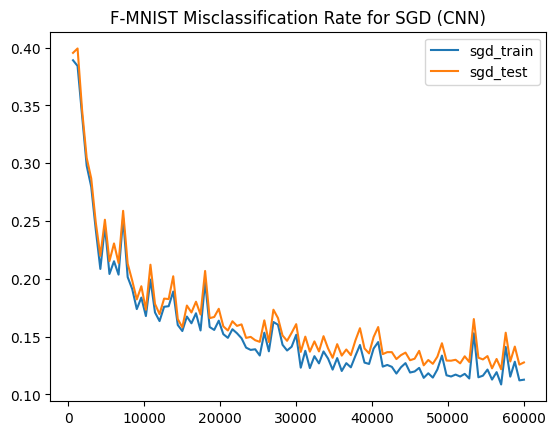

In [24]:
plt.plot(x, y_acc_sgd_fashion_train, label='sgd_train')
plt.plot(x, y_acc_sgd_fashion_test, label='sgd_test')
plt.title('F-MNIST Misclassification Rate for SGD (CNN)')
plt.legend();

In [25]:
# Delete parameters from memory
del state_sgd_fashion, result_sgd_fashion

## 8.2 FDEKF

In [29]:
config.init_var=4e-2
state_fdekf_cnn_fashion, state_fdekf_param_cnn_fashion, result_fdekf_cnn_fashion = train_and_evaluate_ekf(train_ds_fashion, test_ds_fashion, config, 'fdekf', large_params=True, immer_linearize=False)

Params size = (421642,)


test_nll = 0.34495168924331665: 100%|██████████| 60000/60000 [13:39<00:00, 73.25it/s] 


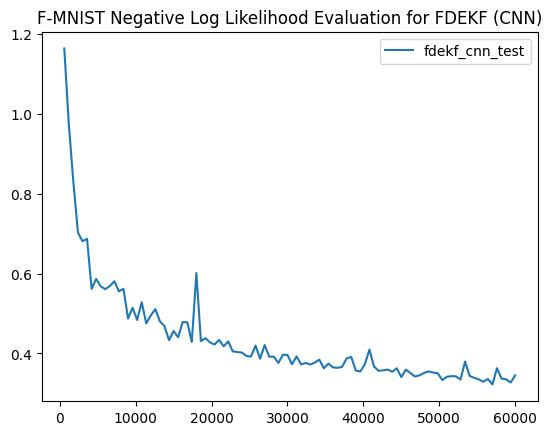

In [34]:
params_interval = 600
x = jnp.arange(params_interval, len(train_ds['image'])+1, params_interval)
fig, ax = plt.subplots()
ax.plot(x, result_fdekf_cnn_fashion[f'nll_test_per_{params_interval}_batches'], label='fdekf_cnn_test')
ax.set_title('F-MNIST Negative Log Likelihood Evaluation for FDEKF (CNN)')
ax.legend();

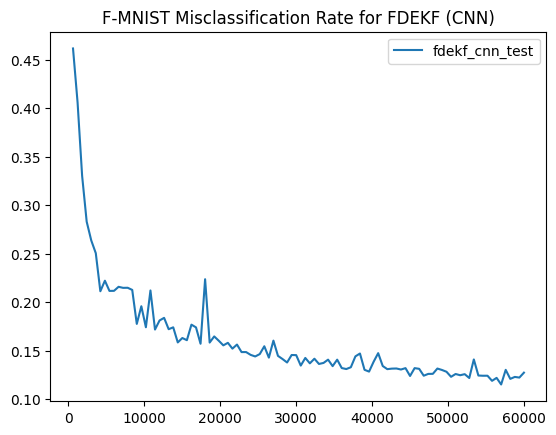

In [37]:
fig, ax = plt.subplots()
ax.plot(x, result_fdekf_cnn_fashion[f'acc_test_per_{params_interval}_batches'], label='fdekf_cnn_test')
ax.set_title('F-MNIST Misclassification Rate for FDEKF (CNN)')
ax.legend();

## 8.3 VDEKF

In [30]:
config.init_var=4e-2
state_vdekf_cnn_fashion, state_vdekf_param_cnn_fashion, result_vdekf_cnn_fashion = train_and_evaluate_ekf(train_ds_fashion, test_ds_fashion, config, 'vdekf', large_params=True, immer_linearize=False)

Params size = (421642,)


test_nll = 0.31246310472488403: 100%|██████████| 60000/60000 [13:40<00:00, 73.11it/s] 


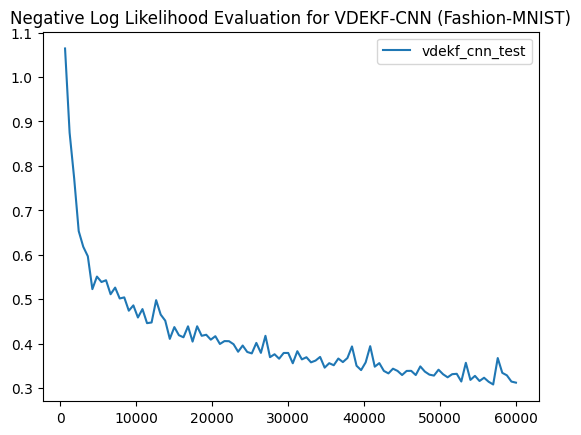

In [35]:
fig, ax = plt.subplots()
ax.plot(x, result_vdekf_cnn_fashion[f'nll_test_per_{params_interval}_batches'], label='vdekf_cnn_test')
ax.set_title('Negative Log Likelihood Evaluation for VDEKF-CNN (Fashion-MNIST)')
ax.legend();

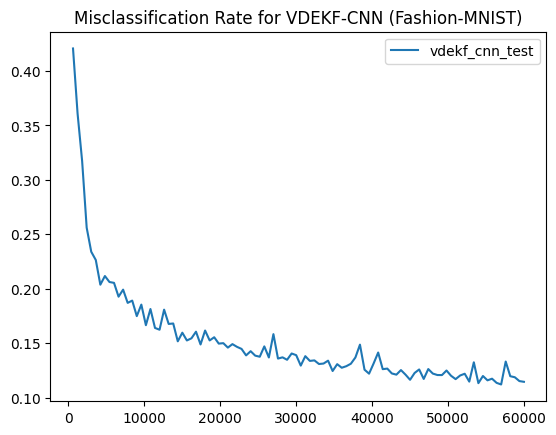

In [36]:
fig, ax = plt.subplots()
ax.plot(x, result_vdekf_cnn_fashion[f'acc_test_per_{params_interval}_batches'], label='vdekf_cnn_test')
ax.set_title('Misclassification Rate for VDEKF-CNN (Fashion-MNIST)')
ax.legend();

## 8.4 Model Comparison (SGD vs FDEKF vs VDEKF)

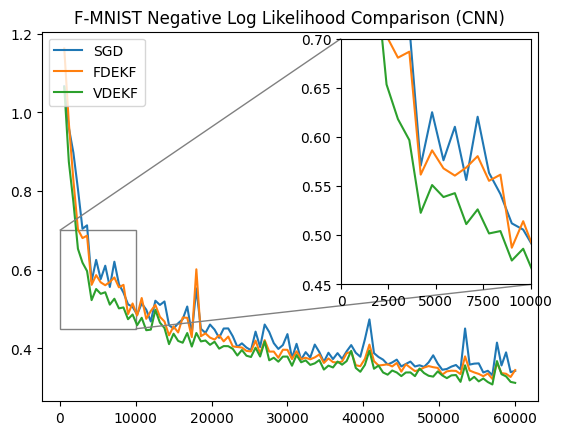

In [48]:
fig, ax = plt.subplots()
ax.plot(x, y_nll_sgd_fashion_test, label='SGD')
ax.plot(x, result_fdekf_cnn_fashion[f'nll_test_per_{params_interval}_batches'], label='FDEKF')
ax.plot(x, result_vdekf_cnn_fashion[f'nll_test_per_{params_interval}_batches'], label='VDEKF')
ax.set_title('F-MNIST Negative Log Likelihood Comparison (CNN)')
ax.legend(loc=2);
axins = zoomed_inset_axes(ax, 2.5, loc=1)
axins.plot(x, y_nll_sgd_fashion_test, label='SGD')
axins.plot(x, result_fdekf_cnn_fashion[f'nll_test_per_{params_interval}_batches'], label='FDEKF')
axins.plot(x, result_vdekf_cnn_fashion[f'nll_test_per_{params_interval}_batches'], label='VDEKF')
axins.set_xlim(0, 10000)
axins.set_ylim(0.45, 0.7)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
fig.savefig('nll_comparison_fmnist.jpg')

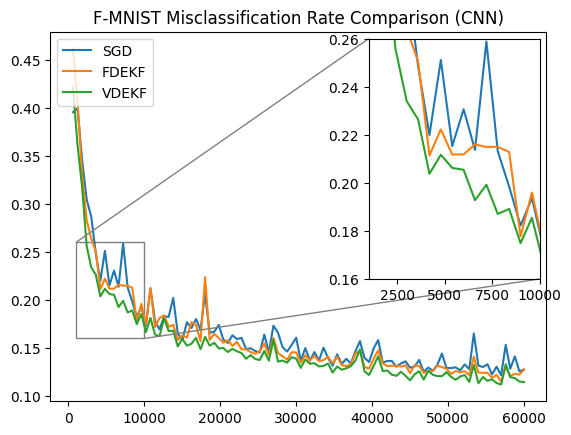

In [43]:
fig, ax = plt.subplots()
ax.plot(x, y_acc_sgd_fashion_test, label='SGD')
ax.plot(x, result_fdekf_cnn_fashion[f'acc_test_per_{params_interval}_batches'], label='FDEKF')
ax.plot(x, result_vdekf_cnn_fashion[f'acc_test_per_{params_interval}_batches'], label='VDEKF')
ax.set_title('F-MNIST Misclassification Rate Comparison (CNN)')
ax.legend(loc=2);
axins = zoomed_inset_axes(ax, 2.5, loc=1)
axins.plot(x, y_acc_sgd_fashion_test, label='SGD')
axins.plot(x, result_fdekf_cnn_fashion[f'acc_test_per_{params_interval}_batches'], label='FDEKF')
axins.plot(x, result_vdekf_cnn_fashion[f'acc_test_per_{params_interval}_batches'], label='VDEKF')
axins.set_xlim(1000, 10000)
axins.set_ylim(0.16, 0.26)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
fig.savefig('acc_comparison_fmnist.jpg')